In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
import operator
import datetime
import sklearn 
from sklearn import linear_model
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [2]:
def RMSPE(test,pred):
    # 在特征工程中，Sales被取对数，这里计算评分时要还原
    pred = np.e**pred
    return np.sqrt(np.mean(((test-pred)/pred)**2))

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [3]:
store = pd.read_csv('store.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

D:\DevSofeware\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
test.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [5]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


d :样本号，无参考作用。 Store:门店号，1~1115，不编码。 Sales :销售额（本项目的预测内容）。 Customers:日客流量。预测集不提供，考虑将该特征整合入店铺特征d :样本号，无参考作用。 Store:门店号，1~1115，不编码。 Sales :销售额（本项目的预测内容）。 Customers:日客流量。预测集不提供，考虑将该特征整合入店铺特征中 Open:用来表征商店开张或闭店的数据，0表示闭店，1表示开张。 StateHoliday:法定假期，a表示公共假期，b表示复活节，c表示圣诞节，0则意味着不是假期。 SchoolHoliday:0,1数值，不需要处理 StoreType:使用a,b,c,d四个值来表征四种不同类型的商店，应当独立热码 Assortment:表征所售商品品类的等级，a为基础型，b为大型，c为特大型。应当独立热码 CompetitionDistance:距离最近竞争商家的距离（m）。连续数值量，考虑放缩 CompetitionOpenSinceMonth:距离最近竞争商家的开业时间月份 CompetitionOpenSinceyear:距离最近竞争商家的开业时间年份 Promo:表征某天是否有促销活动。 Promo2:表征门店是否在持续推出促销活动 Promo2Since[Year/Week]: 以年和年中周数表征该门店参与持续促销的时间。日期量，以分割为年和月 PromoInterval:'Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', nan,四种取值，考虑独立热码为 is_interval,is_fman,is_jajo,is_mjsd中 Open:用来表征商店开张或闭店的数据，0表示闭店，1表示开张。 StateHoliday:法定假期，a表示公共假期，b表示复活节，c表示圣诞节，0则意味着不是假期。 SchoolHoliday:0,1数值，不需要处理 StoreType:使用a,b,c,d四个值来表征四种不同类型的商店，应当独立热码 Assortment:表征所售商品品类的等级，a为基础型，b为大型，c为特大型。应当独立热码 CompetitionDistance:距离最近竞争商家的距离（m）。连续数值量，考虑放缩 CompetitionOpenSinceMonth:距离最近竞争商家的开业时间月份 CompetitionOpenSinceyear:距离最近竞争商家的开业时间年份 Promo:表征某天是否有促销活动。 Promo2:表征门店是否在持续推出促销活动 Promo2Since[Year/Week]: 以年和年中周数表征该门店参与持续促销的时间。日期量，以分割为年和月 PromoInterval:'Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', nan,四种取值，考虑独立热码为 is_interval,is_fman,is_jajo,is_mjsd

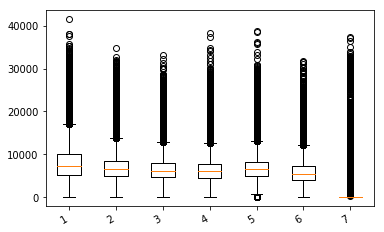

In [7]:
init_explore_fig = plt.figure(figsize=(20,4))
train_weekday = [train[train.DayOfWeek==i].Sales.values for i in [1,2,3,4,5,6,7]]
ief = init_explore_fig.add_subplot(131)
ief.boxplot(train_weekday)
plt.gcf().autofmt_xdate()
plt.show()

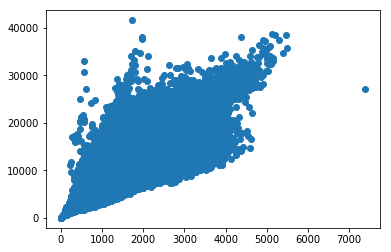

In [8]:
plt.scatter(train.Customers,train.Sales)
plt.show()

数据处理

In [9]:
#test
#Open有11个缺失值，根据Date、StateHoliday、SchoolHoliday所以只是把Open转化int格式
test['Open'] = test['Open'].fillna(1).astype(int)

#处理train
#Open没有缺失值，所以只是把Open转化int格式
train['Open'] = train['Open'].astype(int)

In [10]:
#对日期型数据进行处理
#处理test

#进行Date进行处理，首先转化为时间格式，把Date拆成year，month和day
test['Date']=pd.to_datetime(test['Date'])
test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
#WeekOfYear为Date得出在一年中的第几周
test['WeekOfYear']=test['Date'].dt.weekofyear
#DayOfWeek根据日期来计算，是这一周中
test['DayOfWeek']=test['Date'].dt.dayofweek


#对日期型数据进行处理,train
#进行Date进行处理，首先转化为时间格式，把Date拆成year，month和day
train['Date']=pd.to_datetime(train['Date'])
train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
#WeekOfYear为Date得出在一年中的第几周
train['WeekOfYear']=train['Date'].dt.weekofyear
#DayOfWeek根据日期来计算，是这一周中
train['DayOfWeek']=train['Date'].dt.dayofweek

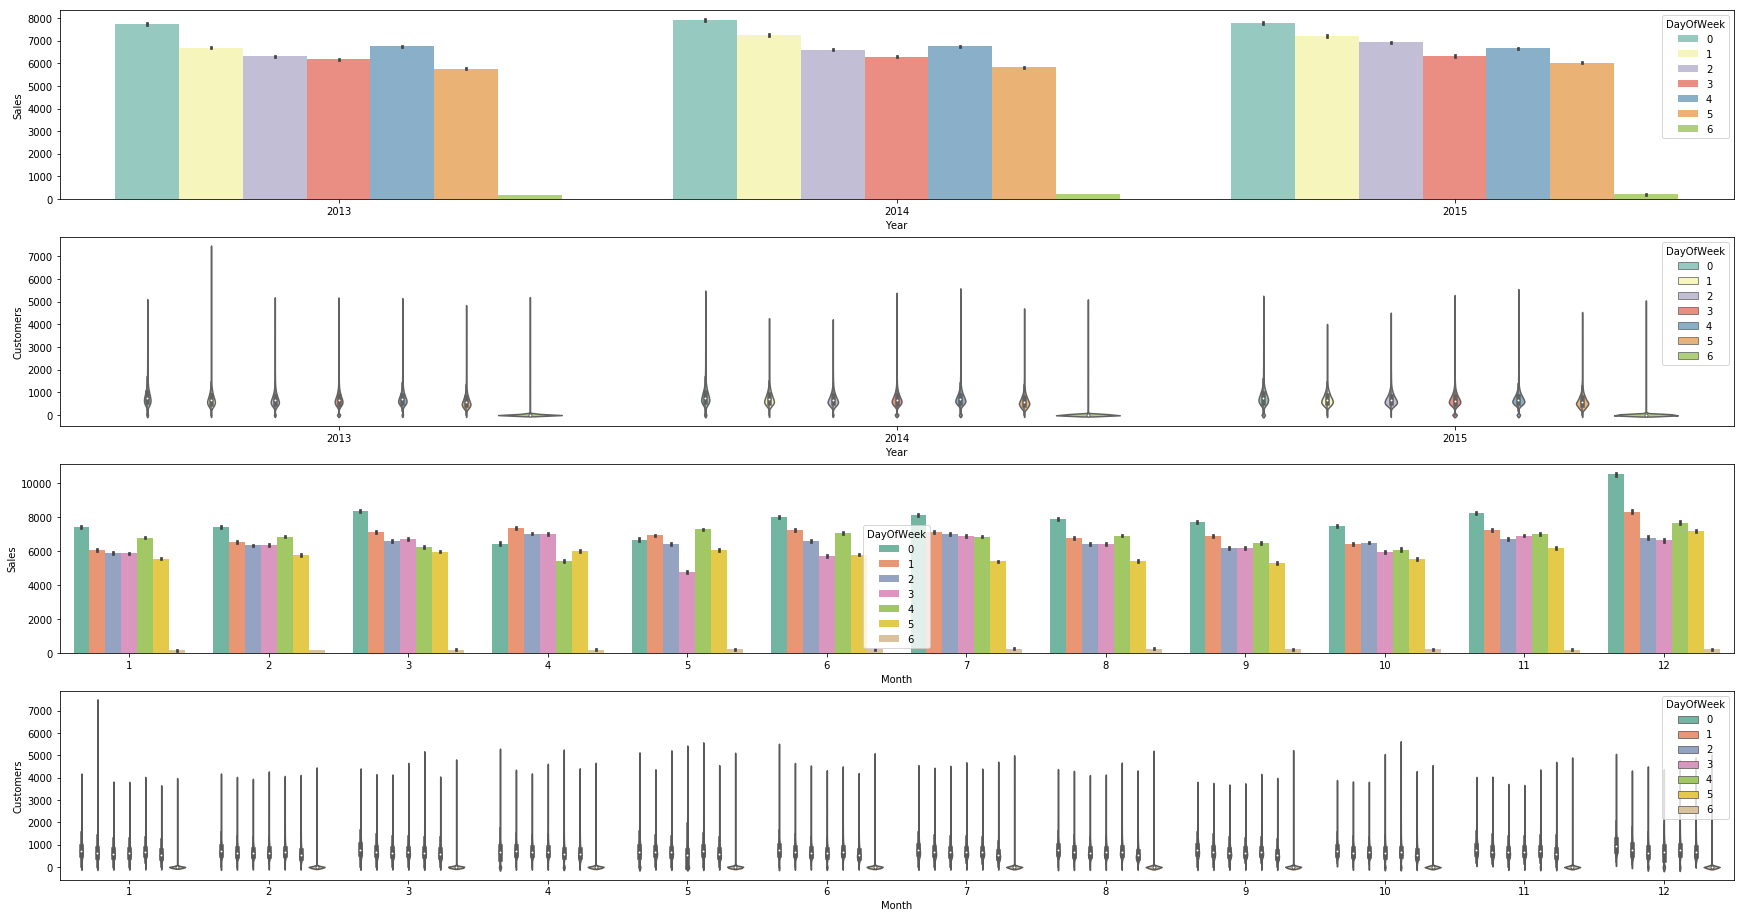

In [11]:
fig, axes = plt.subplots(4,1)
fig.set_size_inches(30, 16)
sns.barplot(x="Year", y="Sales", data=train ,hue="DayOfWeek",ax = axes[0],palette="Set3")
sns.violinplot(x="Year", y="Customers", data=train ,hue="DayOfWeek",ax = axes[1],palette="Set3")
sns.barplot(x="Month", y="Sales", data=train ,hue="DayOfWeek", ax = axes[2],palette="Set2")
sns.violinplot(x="Month", y="Customers", data=train ,hue="DayOfWeek", ax = axes[3],palette="Set2")
plt.show()

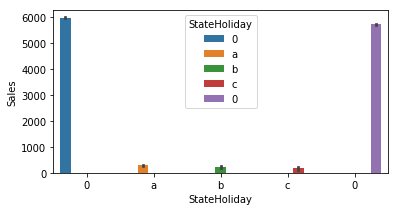

In [12]:
#StateHoliday对特征分析
fig, axes = plt.subplots(1,1)
fig.set_size_inches(6,3)
sns.barplot(x="StateHoliday", y="Sales", data=train ,hue="StateHoliday")
plt.show()
#把StateHoliday取值为a、b、c取值都转化为1，否则为0
train["StateHoliday"] = train["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
train['StateHoliday'] = train['StateHoliday'].astype(int)

test["StateHoliday"] = test["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
test['StateHoliday'] = test['StateHoliday'].astype(int)

In [13]:
#对SchoolHoliday进行分析
train.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

In [14]:
# 将test数据和store数据合并
test_store = pd.merge(test,store,how='inner',left_on=['Store'],right_on=['Store'])

# 将train数据和store数据合并
train_store = pd.merge(train,store,how='inner',left_on=['Store'],right_on=['Store'])

In [15]:
#处理CompetitionDistance
train_store['CompetitionDistance']=train_store['CompetitionDistance'].fillna(9999)
test_store['CompetitionDistance']=test_store['CompetitionDistance'].fillna(9999)

train_store['CompetitionOpenSinceMonth']=train_store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median())
test_store['CompetitionOpenSinceMonth']=test_store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median())

train_store['CompetitionMonths']=(train_store['Year']-train_store['CompetitionOpenSinceYear'])*12+(train_store['Month']-train_store['CompetitionOpenSinceMonth'])
test_store['CompetitionMonths']=(test_store['Year']-test_store['CompetitionOpenSinceYear'])*12+(test_store['Month']-test_store['CompetitionOpenSinceMonth'])

train_store.loc[train_store['CompetitionMonths']<0,'CompetitionMonths']=0
test_store.loc[test_store['CompetitionMonths']<0,'CompetitionMonths']=0

train_store['CompetitionMonths']=train_store['CompetitionMonths'].fillna(0)
test_store['CompetitionMonths']=test_store['CompetitionMonths'].fillna(0)

In [16]:
train_store['Promo2SinceWeek']=train_store['Promo2SinceWeek'].fillna(0)
test_store['Promo2SinceWeek']=test_store['Promo2SinceWeek'].fillna(0)

In [17]:

train_store['Promo2weeks']=train_store['Promo2']*((train_store['Year']-train_store['Promo2SinceYear'])*54+(train_store['WeekOfYear']-train_store['Promo2SinceWeek']))

test_store['Promo2weeks']=test_store['Promo2']*((test_store['Year']-test_store['Promo2SinceYear'])*54+(test_store['WeekOfYear']-test_store['Promo2SinceWeek']))

train_store.loc[train_store['Promo2weeks']<0,'Promo2weeks']=0
test_store.loc[test_store['Promo2weeks']<0,'Promo2weeks']=0

train_store['Promo2weeks']=train_store['Promo2weeks'].fillna(0)
test_store['Promo2weeks']=test_store['Promo2weeks'].fillna(0)

In [18]:
#对门店字段StoreType、Assortment根据时间序列进行独热编码
train_store = pd.get_dummies(train_store,columns=['StoreType','Assortment','StateHoliday'])
test_store = pd.get_dummies(test_store,columns=['StoreType','Assortment','StateHoliday'])

In [19]:
train_store["Promo2weeks"] =train_store["Promo2weeks"].astype(int)
train_store["CompetitionMonths"] =train_store["CompetitionMonths"].astype(int)
train_store["StoreType_a"] =train_store["StoreType_a"].astype(int)
train_store["StoreType_b"] =train_store["StoreType_b"].astype(int)
train_store["StoreType_c"] =train_store["StoreType_c"].astype(int)
train_store["StoreType_d"] =train_store["StoreType_d"].astype(int)
train_store["Assortment_a"] =train_store["Assortment_a"].astype(int)
train_store["Assortment_b"] =train_store["Assortment_b"].astype(int)
train_store["Assortment_c"] =train_store["Assortment_c"].astype(int)

test_store["Promo2weeks"] =test_store["Promo2weeks"].astype(int)
test_store["CompetitionMonths"] =test_store["CompetitionMonths"].astype(int)
test_store["StoreType_a"] =test_store["StoreType_a"].astype(int)
test_store["StoreType_b"] =test_store["StoreType_b"].astype(int)
test_store["StoreType_c"] =test_store["StoreType_c"].astype(int)
test_store["StoreType_d"] =test_store["StoreType_d"].astype(int)
test_store["Assortment_a"] =test_store["Assortment_a"].astype(int)
test_store["Assortment_b"] =test_store["Assortment_b"].astype(int)
test_store["Assortment_c"] =test_store["Assortment_c"].astype(int)

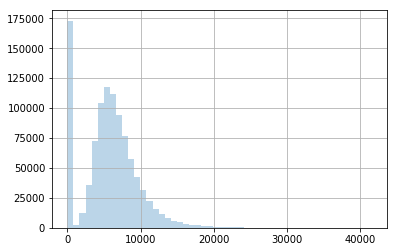

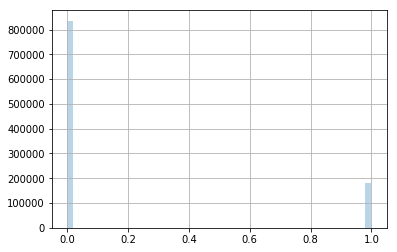

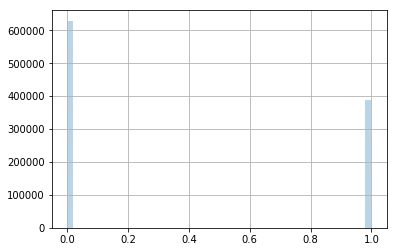

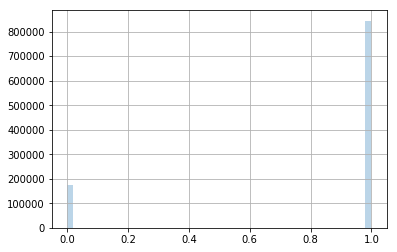

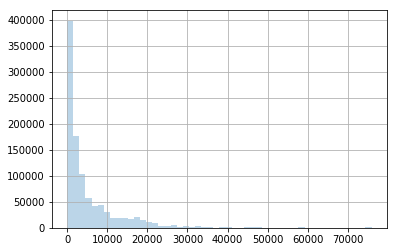

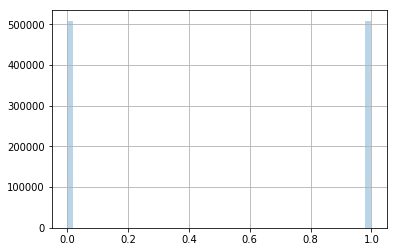

In [20]:
#观察每个变量的分布情况
wide_features = ['Sales','SchoolHoliday','Promo','Open','CompetitionDistance','Promo2']
for feature in wide_features:
    train_store[feature].hist(alpha=0.3,bins=50)
    plt.show()

In [21]:
train_data = train_store[train_store['Open'] == 1]

test_data = test_store[test_store['Open'] == 1]

In [22]:
train_data.to_csv('train_data.csv',index=False)
test_data.to_csv('test_data.csv',index=False)

In [23]:
train_store = pd.read_csv('train_data.csv')
test_store = pd.read_csv('test_data.csv')

In [24]:
test_store.set_index(['Id'],inplace=True)

In [25]:
train = train_store[train_store["Date"]<= '2015-07-10']
val= train_store[train_store["Date"]> '2015-07-10']

columns = ['Store','DayOfWeek','Open','Promo','SchoolHoliday','Year','Month','Day',
'WeekOfYear','CompetitionDistance','Promo2','Assortment_a','Assortment_b',
'Assortment_c','StoreType_a','StoreType_b','StoreType_c','StoreType_d',
'CompetitionMonths','Promo2weeks','StateHoliday_0','StateHoliday_1']

X_train = train[columns]
y_train = train['Sales']
X_val = val[columns]
y_val = val['Sales']


X_test = test_store[columns]

In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 1 to 41088
Data columns (total 22 columns):
Store                  35104 non-null int64
DayOfWeek              35104 non-null int64
Open                   35104 non-null int64
Promo                  35104 non-null int64
SchoolHoliday          35104 non-null int64
Year                   35104 non-null int64
Month                  35104 non-null int64
Day                    35104 non-null int64
WeekOfYear             35104 non-null int64
CompetitionDistance    35104 non-null float64
Promo2                 35104 non-null int64
Assortment_a           35104 non-null int64
Assortment_b           35104 non-null int64
Assortment_c           35104 non-null int64
StoreType_a            35104 non-null int64
StoreType_b            35104 non-null int64
StoreType_c            35104 non-null int64
StoreType_d            35104 non-null int64
CompetitionMonths      35104 non-null int64
Promo2weeks            35104 non-null int64
StateHoli

In [27]:
# 验证数据占训练数据百分比
val_rate = len(y_val)/(len(y_train)+len(y_val))
val_rate

0.023837269893603918

In [28]:
%%time
RF_alpha = RandomForestRegressor()
RF_alpha.fit(X_train,np.log1p(y_train))

Wall time: 54.7 s


In [29]:
%%time
y_pred = RF_alpha.predict(X_val)

Wall time: 90 ms


In [30]:
rf_rmspe = RMSPE(y_val,y_pred)

In [31]:
rf_rmspe

1.4861443192712251

In [32]:
%%time
#使用GridSearchCV进行调优
param_grid = {'max_features': [0.6,0.8,1],'max_depth':[6,7,8]}
rf = RandomForestRegressor() 
rf_grid = GridSearchCV(rf, param_grid=param_grid, cv=10, n_jobs=8, refit=True)
rf_grid.fit(X_train,y_train)

Wall time: 10min 25s


In [33]:
%%time
y_pred = rf_grid.predict(X_val)

Wall time: 2.35 s


In [34]:
rf_rmspe = RMSPE(y_val,y_pred)
rf_rmspe

D:\DevSofeware\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


nan

In [35]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.08
          }
num_trees = 100

In [36]:
%%time
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:7.60727	eval-rmse:7.64911	train-rmspe:0.999592	eval-rmspe:0.999641
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.00005	eval-rmse:7.03823	train-rmspe:0.999138	eval-rmspe:0.999205
[2]	train-rmse:6.4416	eval-rmse:6.47954	train-rmspe:0.998395	eval-rmspe:0.998493
[3]	train-rmse:5.9279	eval-rmse:5.96293	train-rmspe:0.997231	eval-rmspe:0.99737
[4]	train-rmse:5.45546	eval-rmse:5.48993	train-rmspe:0.995484	eval-rmspe:0.995688
[5]	train-rmse:5.02078	eval-rmse:5.05334	train-rmspe:0.992968	eval-rmspe:0.993255
[6]	train-rmse:4.62102	eval-rmse:4.6514	train-rmspe:0.989465	eval-rmspe:0.989858
[7]	train-rmse:4.25331	eval-rmse:4.28177	train-rmspe:0.984756	eval-rmspe:0.985282
[8]	train-rmse:3.91531	eval-rmse:3.94364	train-rmspe:0.97859	eval-rmspe:0.979306
[9]	train-rmse:3.60432	eval-rmse:3.63079	train-rmspe:0.970788	eval-rmspe:0.971698
[10]	train-rmse:3.3184	eval-rmse:3.3445

[96]	train-rmse:0.204756	eval-rmse:0.201968	train-rmspe:0.241649	eval-rmspe:0.206978
[97]	train-rmse:0.203681	eval-rmse:0.201106	train-rmspe:0.240953	eval-rmspe:0.206164
[98]	train-rmse:0.202071	eval-rmse:0.199758	train-rmspe:0.239469	eval-rmspe:0.204784
[99]	train-rmse:0.200023	eval-rmse:0.197871	train-rmspe:0.237602	eval-rmspe:0.202966
Wall time: 1min 24s


In [37]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm.predict(dtest)
error = RMSPE(y_val, yhat)
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.210869
Wall time: 234 ms


In [38]:
result_0=pd.DataFrame({"Id": test.query('Open==0')['Id'], 'Sales':0})

In [39]:
dtest = xgb.DMatrix(X_test)
yhat = gbm.predict(dtest)

In [40]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_100.csv", index=False)

41088


In [41]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.08
          }
num_trees = 300

In [42]:
%%time
gbm_300 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:7.60727	eval-rmse:7.64911	train-rmspe:0.999592	eval-rmspe:0.999641
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.00005	eval-rmse:7.03823	train-rmspe:0.999138	eval-rmspe:0.999205
[2]	train-rmse:6.4416	eval-rmse:6.47954	train-rmspe:0.998395	eval-rmspe:0.998493
[3]	train-rmse:5.9279	eval-rmse:5.96293	train-rmspe:0.997231	eval-rmspe:0.99737
[4]	train-rmse:5.45546	eval-rmse:5.48993	train-rmspe:0.995484	eval-rmspe:0.995688
[5]	train-rmse:5.02078	eval-rmse:5.05334	train-rmspe:0.992968	eval-rmspe:0.993255
[6]	train-rmse:4.62102	eval-rmse:4.6514	train-rmspe:0.989465	eval-rmspe:0.989858
[7]	train-rmse:4.25331	eval-rmse:4.28177	train-rmspe:0.984756	eval-rmspe:0.985282
[8]	train-rmse:3.91531	eval-rmse:3.94364	train-rmspe:0.97859	eval-rmspe:0.979306
[9]	train-rmse:3.60432	eval-rmse:3.63079	train-rmspe:0.970788	eval-rmspe:0.971698
[10]	train-rmse:3.3184	eval-rmse:3.3445

[96]	train-rmse:0.204756	eval-rmse:0.201968	train-rmspe:0.241649	eval-rmspe:0.206978
[97]	train-rmse:0.203681	eval-rmse:0.201106	train-rmspe:0.240953	eval-rmspe:0.206164
[98]	train-rmse:0.202071	eval-rmse:0.199758	train-rmspe:0.239469	eval-rmspe:0.204784
[99]	train-rmse:0.200023	eval-rmse:0.197871	train-rmspe:0.237602	eval-rmspe:0.202966
[100]	train-rmse:0.199837	eval-rmse:0.197845	train-rmspe:0.237436	eval-rmspe:0.202937
[101]	train-rmse:0.198853	eval-rmse:0.197195	train-rmspe:0.236163	eval-rmspe:0.202215
[102]	train-rmse:0.197579	eval-rmse:0.196067	train-rmspe:0.234896	eval-rmspe:0.201043
[103]	train-rmse:0.197266	eval-rmse:0.195756	train-rmspe:0.234567	eval-rmspe:0.200657
[104]	train-rmse:0.197063	eval-rmse:0.195591	train-rmspe:0.234411	eval-rmspe:0.200523
[105]	train-rmse:0.196665	eval-rmse:0.195205	train-rmspe:0.234329	eval-rmspe:0.20016
[106]	train-rmse:0.195111	eval-rmse:0.193973	train-rmspe:0.232949	eval-rmspe:0.198927
[107]	train-rmse:0.192649	eval-rmse:0.191516	train-rmspe:0.

[192]	train-rmse:0.146701	eval-rmse:0.151129	train-rmspe:0.183334	eval-rmspe:0.152007
[193]	train-rmse:0.146267	eval-rmse:0.150926	train-rmspe:0.182648	eval-rmspe:0.15171
[194]	train-rmse:0.146027	eval-rmse:0.150758	train-rmspe:0.182444	eval-rmspe:0.151509
[195]	train-rmse:0.145948	eval-rmse:0.150687	train-rmspe:0.18236	eval-rmspe:0.151432
[196]	train-rmse:0.145832	eval-rmse:0.150599	train-rmspe:0.182149	eval-rmspe:0.151338
[197]	train-rmse:0.145762	eval-rmse:0.150505	train-rmspe:0.182093	eval-rmspe:0.151253
[198]	train-rmse:0.145356	eval-rmse:0.150076	train-rmspe:0.181605	eval-rmspe:0.150778
[199]	train-rmse:0.145281	eval-rmse:0.150006	train-rmspe:0.181547	eval-rmspe:0.150688
[200]	train-rmse:0.145217	eval-rmse:0.149935	train-rmspe:0.18147	eval-rmspe:0.150623
[201]	train-rmse:0.144596	eval-rmse:0.14937	train-rmspe:0.180893	eval-rmspe:0.149975
[202]	train-rmse:0.144211	eval-rmse:0.149077	train-rmspe:0.180531	eval-rmspe:0.149589
[203]	train-rmse:0.143645	eval-rmse:0.148504	train-rmspe:0

[288]	train-rmse:0.122983	eval-rmse:0.131597	train-rmspe:0.15772	eval-rmspe:0.130602
[289]	train-rmse:0.122665	eval-rmse:0.131538	train-rmspe:0.157041	eval-rmspe:0.130539
[290]	train-rmse:0.122509	eval-rmse:0.131541	train-rmspe:0.156962	eval-rmspe:0.130536
[291]	train-rmse:0.12222	eval-rmse:0.131433	train-rmspe:0.156759	eval-rmspe:0.13055
[292]	train-rmse:0.122113	eval-rmse:0.131326	train-rmspe:0.156704	eval-rmspe:0.130449
[293]	train-rmse:0.121852	eval-rmse:0.13123	train-rmspe:0.156551	eval-rmspe:0.130377
[294]	train-rmse:0.121712	eval-rmse:0.131118	train-rmspe:0.156361	eval-rmspe:0.130316
[295]	train-rmse:0.121249	eval-rmse:0.130795	train-rmspe:0.155963	eval-rmspe:0.129936
[296]	train-rmse:0.121134	eval-rmse:0.130695	train-rmspe:0.15586	eval-rmspe:0.129861
[297]	train-rmse:0.121013	eval-rmse:0.130579	train-rmspe:0.155704	eval-rmspe:0.129737
[298]	train-rmse:0.120939	eval-rmse:0.130514	train-rmspe:0.15566	eval-rmspe:0.129668
[299]	train-rmse:0.120799	eval-rmse:0.130442	train-rmspe:0.1

In [43]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm_300.predict(dtest)
error = RMSPE(y_val, yhat)
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.139418
Wall time: 359 ms


In [44]:
dtest = xgb.DMatrix(X_test)
yhat = gbm_300.predict(dtest)

In [45]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_300.csv", index=False)

41088


In [46]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.08
          }
num_trees = 800

In [47]:
%%time
gbm_800 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:7.60727	eval-rmse:7.64911	train-rmspe:0.999592	eval-rmspe:0.999641
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.00005	eval-rmse:7.03823	train-rmspe:0.999138	eval-rmspe:0.999205
[2]	train-rmse:6.4416	eval-rmse:6.47954	train-rmspe:0.998395	eval-rmspe:0.998493
[3]	train-rmse:5.9279	eval-rmse:5.96293	train-rmspe:0.997231	eval-rmspe:0.99737
[4]	train-rmse:5.45546	eval-rmse:5.48993	train-rmspe:0.995484	eval-rmspe:0.995688
[5]	train-rmse:5.02078	eval-rmse:5.05334	train-rmspe:0.992968	eval-rmspe:0.993255
[6]	train-rmse:4.62102	eval-rmse:4.6514	train-rmspe:0.989465	eval-rmspe:0.989858
[7]	train-rmse:4.25331	eval-rmse:4.28177	train-rmspe:0.984756	eval-rmspe:0.985282
[8]	train-rmse:3.91531	eval-rmse:3.94364	train-rmspe:0.97859	eval-rmspe:0.979306
[9]	train-rmse:3.60432	eval-rmse:3.63079	train-rmspe:0.970788	eval-rmspe:0.971698
[10]	train-rmse:3.3184	eval-rmse:3.3445

[96]	train-rmse:0.204756	eval-rmse:0.201968	train-rmspe:0.241649	eval-rmspe:0.206978
[97]	train-rmse:0.203681	eval-rmse:0.201106	train-rmspe:0.240953	eval-rmspe:0.206164
[98]	train-rmse:0.202071	eval-rmse:0.199758	train-rmspe:0.239469	eval-rmspe:0.204784
[99]	train-rmse:0.200023	eval-rmse:0.197871	train-rmspe:0.237602	eval-rmspe:0.202966
[100]	train-rmse:0.199837	eval-rmse:0.197845	train-rmspe:0.237436	eval-rmspe:0.202937
[101]	train-rmse:0.198853	eval-rmse:0.197195	train-rmspe:0.236163	eval-rmspe:0.202215
[102]	train-rmse:0.197579	eval-rmse:0.196067	train-rmspe:0.234896	eval-rmspe:0.201043
[103]	train-rmse:0.197266	eval-rmse:0.195756	train-rmspe:0.234567	eval-rmspe:0.200657
[104]	train-rmse:0.197063	eval-rmse:0.195591	train-rmspe:0.234411	eval-rmspe:0.200523
[105]	train-rmse:0.196665	eval-rmse:0.195205	train-rmspe:0.234329	eval-rmspe:0.20016
[106]	train-rmse:0.195111	eval-rmse:0.193973	train-rmspe:0.232949	eval-rmspe:0.198927
[107]	train-rmse:0.192649	eval-rmse:0.191516	train-rmspe:0.

[192]	train-rmse:0.146701	eval-rmse:0.151129	train-rmspe:0.183334	eval-rmspe:0.152007
[193]	train-rmse:0.146267	eval-rmse:0.150926	train-rmspe:0.182648	eval-rmspe:0.15171
[194]	train-rmse:0.146027	eval-rmse:0.150758	train-rmspe:0.182444	eval-rmspe:0.151509
[195]	train-rmse:0.145948	eval-rmse:0.150687	train-rmspe:0.18236	eval-rmspe:0.151432
[196]	train-rmse:0.145832	eval-rmse:0.150599	train-rmspe:0.182149	eval-rmspe:0.151338
[197]	train-rmse:0.145762	eval-rmse:0.150505	train-rmspe:0.182093	eval-rmspe:0.151253
[198]	train-rmse:0.145356	eval-rmse:0.150076	train-rmspe:0.181605	eval-rmspe:0.150778
[199]	train-rmse:0.145281	eval-rmse:0.150006	train-rmspe:0.181547	eval-rmspe:0.150688
[200]	train-rmse:0.145217	eval-rmse:0.149935	train-rmspe:0.18147	eval-rmspe:0.150623
[201]	train-rmse:0.144596	eval-rmse:0.14937	train-rmspe:0.180893	eval-rmspe:0.149975
[202]	train-rmse:0.144211	eval-rmse:0.149077	train-rmspe:0.180531	eval-rmspe:0.149589
[203]	train-rmse:0.143645	eval-rmse:0.148504	train-rmspe:0

[288]	train-rmse:0.122983	eval-rmse:0.131597	train-rmspe:0.15772	eval-rmspe:0.130602
[289]	train-rmse:0.122665	eval-rmse:0.131538	train-rmspe:0.157041	eval-rmspe:0.130539
[290]	train-rmse:0.122509	eval-rmse:0.131541	train-rmspe:0.156962	eval-rmspe:0.130536
[291]	train-rmse:0.12222	eval-rmse:0.131433	train-rmspe:0.156759	eval-rmspe:0.13055
[292]	train-rmse:0.122113	eval-rmse:0.131326	train-rmspe:0.156704	eval-rmspe:0.130449
[293]	train-rmse:0.121852	eval-rmse:0.13123	train-rmspe:0.156551	eval-rmspe:0.130377
[294]	train-rmse:0.121712	eval-rmse:0.131118	train-rmspe:0.156361	eval-rmspe:0.130316
[295]	train-rmse:0.121249	eval-rmse:0.130795	train-rmspe:0.155963	eval-rmspe:0.129936
[296]	train-rmse:0.121134	eval-rmse:0.130695	train-rmspe:0.15586	eval-rmspe:0.129861
[297]	train-rmse:0.121013	eval-rmse:0.130579	train-rmspe:0.155704	eval-rmspe:0.129737
[298]	train-rmse:0.120939	eval-rmse:0.130514	train-rmspe:0.15566	eval-rmspe:0.129668
[299]	train-rmse:0.120799	eval-rmse:0.130442	train-rmspe:0.1

[384]	train-rmse:0.109569	eval-rmse:0.126156	train-rmspe:0.143214	eval-rmspe:0.123201
[385]	train-rmse:0.109459	eval-rmse:0.126062	train-rmspe:0.143135	eval-rmspe:0.123116
[386]	train-rmse:0.109448	eval-rmse:0.126047	train-rmspe:0.143129	eval-rmspe:0.123105
[387]	train-rmse:0.109383	eval-rmse:0.125998	train-rmspe:0.14305	eval-rmspe:0.123068
[388]	train-rmse:0.109303	eval-rmse:0.125933	train-rmspe:0.142988	eval-rmspe:0.123011
[389]	train-rmse:0.109266	eval-rmse:0.125838	train-rmspe:0.142982	eval-rmspe:0.122942
[390]	train-rmse:0.10914	eval-rmse:0.125734	train-rmspe:0.142881	eval-rmspe:0.122828
[391]	train-rmse:0.109031	eval-rmse:0.125656	train-rmspe:0.142786	eval-rmspe:0.122777
[392]	train-rmse:0.108994	eval-rmse:0.125636	train-rmspe:0.142766	eval-rmspe:0.122757
[393]	train-rmse:0.108925	eval-rmse:0.125602	train-rmspe:0.142722	eval-rmspe:0.122721
[394]	train-rmse:0.108802	eval-rmse:0.125672	train-rmspe:0.142627	eval-rmspe:0.122686
[395]	train-rmse:0.1087	eval-rmse:0.125604	train-rmspe:0

[480]	train-rmse:0.100895	eval-rmse:0.12424	train-rmspe:0.1314	eval-rmspe:0.119332
[481]	train-rmse:0.100778	eval-rmse:0.124151	train-rmspe:0.131321	eval-rmspe:0.119236
[482]	train-rmse:0.100686	eval-rmse:0.124101	train-rmspe:0.131256	eval-rmspe:0.119183
[483]	train-rmse:0.100633	eval-rmse:0.124054	train-rmspe:0.131183	eval-rmspe:0.119152
[484]	train-rmse:0.100526	eval-rmse:0.124192	train-rmspe:0.131118	eval-rmspe:0.119075
[485]	train-rmse:0.100508	eval-rmse:0.124139	train-rmspe:0.131066	eval-rmspe:0.119081
[486]	train-rmse:0.100348	eval-rmse:0.124112	train-rmspe:0.13099	eval-rmspe:0.119024
[487]	train-rmse:0.100231	eval-rmse:0.124101	train-rmspe:0.130923	eval-rmspe:0.119005
[488]	train-rmse:0.100116	eval-rmse:0.12402	train-rmspe:0.130838	eval-rmspe:0.118935
[489]	train-rmse:0.100059	eval-rmse:0.123976	train-rmspe:0.130797	eval-rmspe:0.118893
[490]	train-rmse:0.09997	eval-rmse:0.123953	train-rmspe:0.13072	eval-rmspe:0.118879
[491]	train-rmse:0.09994	eval-rmse:0.123926	train-rmspe:0.130

[576]	train-rmse:0.094514	eval-rmse:0.12424	train-rmspe:0.119627	eval-rmspe:0.117289
[577]	train-rmse:0.094472	eval-rmse:0.124244	train-rmspe:0.119598	eval-rmspe:0.117291
[578]	train-rmse:0.094395	eval-rmse:0.124271	train-rmspe:0.119545	eval-rmspe:0.117294
[579]	train-rmse:0.094353	eval-rmse:0.12425	train-rmspe:0.119509	eval-rmspe:0.117274
[580]	train-rmse:0.094269	eval-rmse:0.124277	train-rmspe:0.119465	eval-rmspe:0.117263
[581]	train-rmse:0.094225	eval-rmse:0.124262	train-rmspe:0.119436	eval-rmspe:0.117239
[582]	train-rmse:0.094149	eval-rmse:0.124261	train-rmspe:0.119389	eval-rmspe:0.117221
[583]	train-rmse:0.094087	eval-rmse:0.124225	train-rmspe:0.119346	eval-rmspe:0.117183
[584]	train-rmse:0.094015	eval-rmse:0.124485	train-rmspe:0.119303	eval-rmspe:0.117219
[585]	train-rmse:0.09395	eval-rmse:0.124483	train-rmspe:0.119262	eval-rmspe:0.117206
[586]	train-rmse:0.093882	eval-rmse:0.124466	train-rmspe:0.119211	eval-rmspe:0.117197
[587]	train-rmse:0.093771	eval-rmse:0.124409	train-rmspe:

[672]	train-rmse:0.08923	eval-rmse:0.123596	train-rmspe:0.103012	eval-rmspe:0.115374
[673]	train-rmse:0.089191	eval-rmse:0.123583	train-rmspe:0.102987	eval-rmspe:0.115364
[674]	train-rmse:0.08917	eval-rmse:0.123585	train-rmspe:0.102968	eval-rmspe:0.115364
[675]	train-rmse:0.089094	eval-rmse:0.123551	train-rmspe:0.102844	eval-rmspe:0.115334
[676]	train-rmse:0.089037	eval-rmse:0.123534	train-rmspe:0.102765	eval-rmspe:0.115317
[677]	train-rmse:0.088961	eval-rmse:0.123486	train-rmspe:0.102713	eval-rmspe:0.115285
[678]	train-rmse:0.088906	eval-rmse:0.123472	train-rmspe:0.102684	eval-rmspe:0.115265
[679]	train-rmse:0.088897	eval-rmse:0.123486	train-rmspe:0.102675	eval-rmspe:0.115277
[680]	train-rmse:0.088861	eval-rmse:0.124549	train-rmspe:0.102656	eval-rmspe:0.115422
[681]	train-rmse:0.088781	eval-rmse:0.124577	train-rmspe:0.102598	eval-rmspe:0.115385
[682]	train-rmse:0.088769	eval-rmse:0.12458	train-rmspe:0.102587	eval-rmspe:0.115397
[683]	train-rmse:0.088745	eval-rmse:0.124568	train-rmspe:

[768]	train-rmse:0.085499	eval-rmse:0.123848	train-rmspe:0.098961	eval-rmspe:0.114448
[769]	train-rmse:0.085458	eval-rmse:0.124	train-rmspe:0.098936	eval-rmspe:0.114489
[770]	train-rmse:0.085439	eval-rmse:0.123999	train-rmspe:0.09892	eval-rmspe:0.114488
[771]	train-rmse:0.08538	eval-rmse:0.124004	train-rmspe:0.098892	eval-rmspe:0.114474
[772]	train-rmse:0.085308	eval-rmse:0.124004	train-rmspe:0.098862	eval-rmspe:0.114479
[773]	train-rmse:0.085277	eval-rmse:0.123988	train-rmspe:0.098817	eval-rmspe:0.114461
[774]	train-rmse:0.085248	eval-rmse:0.123982	train-rmspe:0.098813	eval-rmspe:0.114454
[775]	train-rmse:0.085186	eval-rmse:0.123961	train-rmspe:0.09876	eval-rmspe:0.114434
[776]	train-rmse:0.085166	eval-rmse:0.123943	train-rmspe:0.098741	eval-rmspe:0.114414
[777]	train-rmse:0.085138	eval-rmse:0.123904	train-rmspe:0.098692	eval-rmspe:0.114385
[778]	train-rmse:0.08512	eval-rmse:0.123849	train-rmspe:0.098661	eval-rmspe:0.114367
[779]	train-rmse:0.085091	eval-rmse:0.12385	train-rmspe:0.098

In [48]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm_800.predict(dtest)
error = RMSPE(y_val, yhat)
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.194626
Wall time: 920 ms


In [49]:
dtest = xgb.DMatrix(X_test)
yhat = gbm_800.predict(dtest)

In [50]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_800.csv", index=False)

41088


In [51]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.5,
          "max_depth": 15,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.01
          }
num_trees =2000

In [52]:
%%time
gbm_2000 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.18485	eval-rmse:8.22831	train-rmspe:0.999831	eval-rmspe:0.99987
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.10315	eval-rmse:8.1462	train-rmspe:0.999805	eval-rmspe:0.999845
[2]	train-rmse:8.02229	eval-rmse:8.06534	train-rmspe:0.999777	eval-rmspe:0.999818
[3]	train-rmse:7.94224	eval-rmse:7.98494	train-rmspe:0.999747	eval-rmspe:0.99979
[4]	train-rmse:7.863	eval-rmse:7.90576	train-rmspe:0.999715	eval-rmspe:0.999759
[5]	train-rmse:7.78453	eval-rmse:7.82692	train-rmspe:0.99968	eval-rmspe:0.999726
[6]	train-rmse:7.70685	eval-rmse:7.74887	train-rmspe:0.999643	eval-rmspe:0.999691
[7]	train-rmse:7.62995	eval-rmse:7.67162	train-rmspe:0.999604	eval-rmspe:0.999653
[8]	train-rmse:7.55384	eval-rmse:7.59556	train-rmspe:0.999562	eval-rmspe:0.999613
[9]	train-rmse:7.47846	eval-rmse:7.51993	train-rmspe:0.999517	eval-rmspe:0.99957
[10]	train-rmse:7.40386	eval-rmse:7.44531

[98]	train-rmse:3.07057	eval-rmse:3.0951	train-rmspe:0.950702	eval-rmspe:0.952081
[99]	train-rmse:3.04011	eval-rmse:3.06443	train-rmspe:0.949193	eval-rmspe:0.950602
[100]	train-rmse:3.01002	eval-rmse:3.03414	train-rmspe:0.947641	eval-rmspe:0.949082
[101]	train-rmse:2.98021	eval-rmse:3.00412	train-rmspe:0.946065	eval-rmspe:0.947535
[102]	train-rmse:2.95067	eval-rmse:2.97441	train-rmspe:0.944464	eval-rmspe:0.945965
[103]	train-rmse:2.92147	eval-rmse:2.94499	train-rmspe:0.94282	eval-rmspe:0.944351
[104]	train-rmse:2.89253	eval-rmse:2.91573	train-rmspe:0.941156	eval-rmspe:0.942708
[105]	train-rmse:2.86387	eval-rmse:2.88704	train-rmspe:0.939462	eval-rmspe:0.941054
[106]	train-rmse:2.83552	eval-rmse:2.85859	train-rmspe:0.937731	eval-rmspe:0.939358
[107]	train-rmse:2.80744	eval-rmse:2.83026	train-rmspe:0.935974	eval-rmspe:0.937628
[108]	train-rmse:2.77965	eval-rmse:2.80221	train-rmspe:0.934182	eval-rmspe:0.935862
[109]	train-rmse:2.75213	eval-rmse:2.7745	train-rmspe:0.932366	eval-rmspe:0.9340

[197]	train-rmse:1.15907	eval-rmse:1.17431	train-rmspe:0.674011	eval-rmspe:0.677928
[198]	train-rmse:1.14797	eval-rmse:1.16318	train-rmspe:0.670443	eval-rmspe:0.674355
[199]	train-rmse:1.13695	eval-rmse:1.152	train-rmspe:0.666883	eval-rmspe:0.670759
[200]	train-rmse:1.12605	eval-rmse:1.1411	train-rmspe:0.663322	eval-rmspe:0.667221
[201]	train-rmse:1.11532	eval-rmse:1.13026	train-rmspe:0.659752	eval-rmspe:0.663621
[202]	train-rmse:1.10467	eval-rmse:1.11958	train-rmspe:0.656186	eval-rmspe:0.66004
[203]	train-rmse:1.09411	eval-rmse:1.109	train-rmspe:0.652622	eval-rmspe:0.656472
[204]	train-rmse:1.0837	eval-rmse:1.09861	train-rmspe:0.649034	eval-rmspe:0.652916
[205]	train-rmse:1.07339	eval-rmse:1.08832	train-rmspe:0.645467	eval-rmspe:0.649356
[206]	train-rmse:1.06313	eval-rmse:1.07806	train-rmspe:0.641907	eval-rmspe:0.645799
[207]	train-rmse:1.05297	eval-rmse:1.06791	train-rmspe:0.638355	eval-rmspe:0.642243
[208]	train-rmse:1.0429	eval-rmse:1.05774	train-rmspe:0.634807	eval-rmspe:0.638651


[294]	train-rmse:0.478548	eval-rmse:0.493187	train-rmspe:0.36959	eval-rmspe:0.372735
[295]	train-rmse:0.474611	eval-rmse:0.48927	train-rmspe:0.367209	eval-rmspe:0.370369
[296]	train-rmse:0.470741	eval-rmse:0.485428	train-rmspe:0.364908	eval-rmspe:0.368036
[297]	train-rmse:0.466856	eval-rmse:0.481599	train-rmspe:0.362529	eval-rmspe:0.365705
[298]	train-rmse:0.463095	eval-rmse:0.477963	train-rmspe:0.36014	eval-rmspe:0.36347
[299]	train-rmse:0.45936	eval-rmse:0.473971	train-rmspe:0.357909	eval-rmspe:0.361017
[300]	train-rmse:0.455611	eval-rmse:0.470223	train-rmspe:0.355657	eval-rmspe:0.358723
[301]	train-rmse:0.451841	eval-rmse:0.466443	train-rmspe:0.353426	eval-rmspe:0.356427
[302]	train-rmse:0.448149	eval-rmse:0.46277	train-rmspe:0.351222	eval-rmspe:0.354174
[303]	train-rmse:0.444478	eval-rmse:0.459121	train-rmspe:0.348987	eval-rmspe:0.351924
[304]	train-rmse:0.44086	eval-rmse:0.45555	train-rmspe:0.346725	eval-rmspe:0.349711
[305]	train-rmse:0.437057	eval-rmse:0.451775	train-rmspe:0.344

[390]	train-rmse:0.247495	eval-rmse:0.263831	train-rmspe:0.222609	eval-rmspe:0.223969
[391]	train-rmse:0.246188	eval-rmse:0.262542	train-rmspe:0.221714	eval-rmspe:0.223115
[392]	train-rmse:0.244857	eval-rmse:0.26121	train-rmspe:0.220864	eval-rmspe:0.222222
[393]	train-rmse:0.243701	eval-rmse:0.26006	train-rmspe:0.220163	eval-rmspe:0.221455
[394]	train-rmse:0.242527	eval-rmse:0.25898	train-rmspe:0.219304	eval-rmspe:0.220738
[395]	train-rmse:0.241325	eval-rmse:0.25777	train-rmspe:0.218561	eval-rmspe:0.219935
[396]	train-rmse:0.240134	eval-rmse:0.256675	train-rmspe:0.217545	eval-rmspe:0.219197
[397]	train-rmse:0.239016	eval-rmse:0.255413	train-rmspe:0.216746	eval-rmspe:0.218373
[398]	train-rmse:0.237822	eval-rmse:0.254256	train-rmspe:0.215995	eval-rmspe:0.217603
[399]	train-rmse:0.236522	eval-rmse:0.252963	train-rmspe:0.21512	eval-rmspe:0.216724
[400]	train-rmse:0.235445	eval-rmse:0.252031	train-rmspe:0.21435	eval-rmspe:0.216114
[401]	train-rmse:0.234333	eval-rmse:0.250886	train-rmspe:0.2

[486]	train-rmse:0.17468	eval-rmse:0.192283	train-rmspe:0.17422	eval-rmspe:0.177519
[487]	train-rmse:0.17425	eval-rmse:0.191877	train-rmspe:0.173899	eval-rmspe:0.177272
[488]	train-rmse:0.173814	eval-rmse:0.191403	train-rmspe:0.173624	eval-rmspe:0.17697
[489]	train-rmse:0.173428	eval-rmse:0.191016	train-rmspe:0.173396	eval-rmspe:0.176736
[490]	train-rmse:0.172995	eval-rmse:0.190579	train-rmspe:0.17314	eval-rmspe:0.176447
[491]	train-rmse:0.172671	eval-rmse:0.190345	train-rmspe:0.172972	eval-rmspe:0.176327
[492]	train-rmse:0.172313	eval-rmse:0.189946	train-rmspe:0.172768	eval-rmspe:0.176087
[493]	train-rmse:0.171963	eval-rmse:0.189596	train-rmspe:0.172526	eval-rmspe:0.175891
[494]	train-rmse:0.17162	eval-rmse:0.189268	train-rmspe:0.172256	eval-rmspe:0.175694
[495]	train-rmse:0.171264	eval-rmse:0.18892	train-rmspe:0.172059	eval-rmspe:0.175495
[496]	train-rmse:0.170933	eval-rmse:0.188583	train-rmspe:0.171879	eval-rmspe:0.175293
[497]	train-rmse:0.170508	eval-rmse:0.188155	train-rmspe:0.17

[582]	train-rmse:0.149602	eval-rmse:0.167522	train-rmspe:0.156913	eval-rmspe:0.161976
[583]	train-rmse:0.149191	eval-rmse:0.167146	train-rmspe:0.156549	eval-rmspe:0.161639
[584]	train-rmse:0.148926	eval-rmse:0.166919	train-rmspe:0.156347	eval-rmspe:0.161451
[585]	train-rmse:0.148762	eval-rmse:0.166767	train-rmspe:0.156174	eval-rmspe:0.161356
[586]	train-rmse:0.148631	eval-rmse:0.166638	train-rmspe:0.156096	eval-rmspe:0.161284
[587]	train-rmse:0.148531	eval-rmse:0.166521	train-rmspe:0.156051	eval-rmspe:0.161222
[588]	train-rmse:0.148282	eval-rmse:0.166278	train-rmspe:0.155857	eval-rmspe:0.161014
[589]	train-rmse:0.148045	eval-rmse:0.166062	train-rmspe:0.155687	eval-rmspe:0.16084
[590]	train-rmse:0.147912	eval-rmse:0.166009	train-rmspe:0.155545	eval-rmspe:0.16082
[591]	train-rmse:0.14775	eval-rmse:0.165835	train-rmspe:0.155438	eval-rmspe:0.160692
[592]	train-rmse:0.147542	eval-rmse:0.165638	train-rmspe:0.155293	eval-rmspe:0.16054
[593]	train-rmse:0.14722	eval-rmse:0.165344	train-rmspe:0.

[678]	train-rmse:0.133788	eval-rmse:0.15303	train-rmspe:0.141511	eval-rmspe:0.150543
[679]	train-rmse:0.133633	eval-rmse:0.152881	train-rmspe:0.141373	eval-rmspe:0.150417
[680]	train-rmse:0.133573	eval-rmse:0.152831	train-rmspe:0.141332	eval-rmspe:0.150388
[681]	train-rmse:0.133492	eval-rmse:0.152756	train-rmspe:0.141242	eval-rmspe:0.150343
[682]	train-rmse:0.133428	eval-rmse:0.152723	train-rmspe:0.141171	eval-rmspe:0.15032
[683]	train-rmse:0.133314	eval-rmse:0.152616	train-rmspe:0.141081	eval-rmspe:0.150225
[684]	train-rmse:0.133232	eval-rmse:0.152545	train-rmspe:0.140835	eval-rmspe:0.150182
[685]	train-rmse:0.13305	eval-rmse:0.152392	train-rmspe:0.140628	eval-rmspe:0.150044
[686]	train-rmse:0.132913	eval-rmse:0.152271	train-rmspe:0.140512	eval-rmspe:0.149955
[687]	train-rmse:0.132856	eval-rmse:0.152245	train-rmspe:0.140468	eval-rmspe:0.149942
[688]	train-rmse:0.13275	eval-rmse:0.152234	train-rmspe:0.140344	eval-rmspe:0.149909
[689]	train-rmse:0.132593	eval-rmse:0.152113	train-rmspe:0

[774]	train-rmse:0.121899	eval-rmse:0.143566	train-rmspe:0.127989	eval-rmspe:0.141924
[775]	train-rmse:0.121752	eval-rmse:0.14344	train-rmspe:0.127847	eval-rmspe:0.141802
[776]	train-rmse:0.121552	eval-rmse:0.143304	train-rmspe:0.12762	eval-rmspe:0.141654
[777]	train-rmse:0.12151	eval-rmse:0.143276	train-rmspe:0.127551	eval-rmspe:0.141631
[778]	train-rmse:0.121487	eval-rmse:0.14325	train-rmspe:0.127534	eval-rmspe:0.141614
[779]	train-rmse:0.121362	eval-rmse:0.143142	train-rmspe:0.127424	eval-rmspe:0.141505
[780]	train-rmse:0.12123	eval-rmse:0.14304	train-rmspe:0.127309	eval-rmspe:0.141399
[781]	train-rmse:0.121184	eval-rmse:0.142995	train-rmspe:0.127271	eval-rmspe:0.141362
[782]	train-rmse:0.121125	eval-rmse:0.142967	train-rmspe:0.127204	eval-rmspe:0.141346
[783]	train-rmse:0.121102	eval-rmse:0.142944	train-rmspe:0.127173	eval-rmspe:0.141332
[784]	train-rmse:0.120919	eval-rmse:0.142786	train-rmspe:0.126993	eval-rmspe:0.141172
[785]	train-rmse:0.120854	eval-rmse:0.142767	train-rmspe:0.1

[870]	train-rmse:0.112115	eval-rmse:0.136613	train-rmspe:0.117065	eval-rmspe:0.135006
[871]	train-rmse:0.111959	eval-rmse:0.136502	train-rmspe:0.116845	eval-rmspe:0.134897
[872]	train-rmse:0.111919	eval-rmse:0.136464	train-rmspe:0.116813	eval-rmspe:0.134862
[873]	train-rmse:0.111878	eval-rmse:0.136428	train-rmspe:0.116771	eval-rmspe:0.134829
[874]	train-rmse:0.111832	eval-rmse:0.136413	train-rmspe:0.116726	eval-rmspe:0.134805
[875]	train-rmse:0.111803	eval-rmse:0.136385	train-rmspe:0.1167	eval-rmspe:0.13478
[876]	train-rmse:0.111788	eval-rmse:0.136371	train-rmspe:0.116686	eval-rmspe:0.134768
[877]	train-rmse:0.111754	eval-rmse:0.136341	train-rmspe:0.116659	eval-rmspe:0.134741
[878]	train-rmse:0.111687	eval-rmse:0.136288	train-rmspe:0.116584	eval-rmspe:0.134689
[879]	train-rmse:0.111554	eval-rmse:0.136168	train-rmspe:0.116449	eval-rmspe:0.134559
[880]	train-rmse:0.111479	eval-rmse:0.136149	train-rmspe:0.116359	eval-rmspe:0.134535
[881]	train-rmse:0.111445	eval-rmse:0.136165	train-rmspe:

[966]	train-rmse:0.105595	eval-rmse:0.132078	train-rmspe:0.109691	eval-rmspe:0.130409
[967]	train-rmse:0.105502	eval-rmse:0.13201	train-rmspe:0.109601	eval-rmspe:0.130333
[968]	train-rmse:0.105466	eval-rmse:0.131988	train-rmspe:0.109567	eval-rmspe:0.130307
[969]	train-rmse:0.105415	eval-rmse:0.131962	train-rmspe:0.109512	eval-rmspe:0.130282
[970]	train-rmse:0.10533	eval-rmse:0.131958	train-rmspe:0.109434	eval-rmspe:0.130246
[971]	train-rmse:0.105279	eval-rmse:0.131925	train-rmspe:0.109389	eval-rmspe:0.130207
[972]	train-rmse:0.105258	eval-rmse:0.131913	train-rmspe:0.10937	eval-rmspe:0.130195
[973]	train-rmse:0.105136	eval-rmse:0.131824	train-rmspe:0.109247	eval-rmspe:0.130102
[974]	train-rmse:0.105069	eval-rmse:0.131758	train-rmspe:0.109158	eval-rmspe:0.130038
[975]	train-rmse:0.104967	eval-rmse:0.131716	train-rmspe:0.109058	eval-rmspe:0.129982
[976]	train-rmse:0.104951	eval-rmse:0.131703	train-rmspe:0.109039	eval-rmspe:0.12997
[977]	train-rmse:0.104901	eval-rmse:0.131668	train-rmspe:0

[1062]	train-rmse:0.099543	eval-rmse:0.12827	train-rmspe:0.103235	eval-rmspe:0.126314
[1063]	train-rmse:0.099467	eval-rmse:0.128226	train-rmspe:0.103163	eval-rmspe:0.126272
[1064]	train-rmse:0.099428	eval-rmse:0.128201	train-rmspe:0.10313	eval-rmspe:0.126247
[1065]	train-rmse:0.099374	eval-rmse:0.128179	train-rmspe:0.103084	eval-rmspe:0.126219
[1066]	train-rmse:0.099298	eval-rmse:0.128116	train-rmspe:0.103013	eval-rmspe:0.126159
[1067]	train-rmse:0.099251	eval-rmse:0.128108	train-rmspe:0.102915	eval-rmspe:0.126146
[1068]	train-rmse:0.099199	eval-rmse:0.128074	train-rmspe:0.102865	eval-rmspe:0.126112
[1069]	train-rmse:0.099085	eval-rmse:0.12798	train-rmspe:0.102724	eval-rmspe:0.126017
[1070]	train-rmse:0.099045	eval-rmse:0.127952	train-rmspe:0.102686	eval-rmspe:0.125989
[1071]	train-rmse:0.099036	eval-rmse:0.127943	train-rmspe:0.102676	eval-rmspe:0.12598
[1072]	train-rmse:0.098916	eval-rmse:0.12785	train-rmspe:0.10256	eval-rmspe:0.125886
[1073]	train-rmse:0.098809	eval-rmse:0.127858	tra

[1157]	train-rmse:0.09416	eval-rmse:0.125059	train-rmspe:0.097211	eval-rmspe:0.122919
[1158]	train-rmse:0.09414	eval-rmse:0.125062	train-rmspe:0.097184	eval-rmspe:0.12292
[1159]	train-rmse:0.094076	eval-rmse:0.125026	train-rmspe:0.097085	eval-rmspe:0.122886
[1160]	train-rmse:0.094056	eval-rmse:0.125014	train-rmspe:0.097065	eval-rmspe:0.122874
[1161]	train-rmse:0.093986	eval-rmse:0.124975	train-rmspe:0.097002	eval-rmspe:0.122833
[1162]	train-rmse:0.093921	eval-rmse:0.124956	train-rmspe:0.096945	eval-rmspe:0.12282
[1163]	train-rmse:0.093847	eval-rmse:0.124918	train-rmspe:0.096876	eval-rmspe:0.122776
[1164]	train-rmse:0.093772	eval-rmse:0.124896	train-rmspe:0.096808	eval-rmspe:0.122736
[1165]	train-rmse:0.093761	eval-rmse:0.124889	train-rmspe:0.096795	eval-rmspe:0.122729
[1166]	train-rmse:0.093709	eval-rmse:0.124875	train-rmspe:0.096748	eval-rmspe:0.122699
[1167]	train-rmse:0.093697	eval-rmse:0.124865	train-rmspe:0.09673	eval-rmspe:0.122689
[1168]	train-rmse:0.093576	eval-rmse:0.1248	trai

[1252]	train-rmse:0.089548	eval-rmse:0.123306	train-rmspe:0.092395	eval-rmspe:0.120696
[1253]	train-rmse:0.089511	eval-rmse:0.123307	train-rmspe:0.092363	eval-rmspe:0.120686
[1254]	train-rmse:0.089474	eval-rmse:0.123292	train-rmspe:0.092329	eval-rmspe:0.120672
[1255]	train-rmse:0.089445	eval-rmse:0.123272	train-rmspe:0.0923	eval-rmspe:0.120651
[1256]	train-rmse:0.08939	eval-rmse:0.123238	train-rmspe:0.092247	eval-rmspe:0.120616
[1257]	train-rmse:0.089331	eval-rmse:0.123208	train-rmspe:0.092185	eval-rmspe:0.120578
[1258]	train-rmse:0.089326	eval-rmse:0.123204	train-rmspe:0.092182	eval-rmspe:0.120575
[1259]	train-rmse:0.089272	eval-rmse:0.123166	train-rmspe:0.092126	eval-rmspe:0.120533
[1260]	train-rmse:0.089195	eval-rmse:0.123118	train-rmspe:0.092046	eval-rmspe:0.12048
[1261]	train-rmse:0.089159	eval-rmse:0.123094	train-rmspe:0.092008	eval-rmspe:0.120455
[1262]	train-rmse:0.089107	eval-rmse:0.123064	train-rmspe:0.091957	eval-rmspe:0.120423
[1263]	train-rmse:0.0891	eval-rmse:0.123061	tra

[1347]	train-rmse:0.086015	eval-rmse:0.122085	train-rmspe:0.088781	eval-rmspe:0.119053
[1348]	train-rmse:0.085998	eval-rmse:0.122074	train-rmspe:0.088765	eval-rmspe:0.119041
[1349]	train-rmse:0.085962	eval-rmse:0.122079	train-rmspe:0.088731	eval-rmspe:0.11903
[1350]	train-rmse:0.085882	eval-rmse:0.122029	train-rmspe:0.088649	eval-rmspe:0.118976
[1351]	train-rmse:0.085848	eval-rmse:0.12201	train-rmspe:0.088608	eval-rmspe:0.118956
[1352]	train-rmse:0.085822	eval-rmse:0.121993	train-rmspe:0.088582	eval-rmspe:0.118939
[1353]	train-rmse:0.08581	eval-rmse:0.121989	train-rmspe:0.08857	eval-rmspe:0.118936
[1354]	train-rmse:0.085779	eval-rmse:0.121988	train-rmspe:0.088544	eval-rmspe:0.118934
[1355]	train-rmse:0.085751	eval-rmse:0.121976	train-rmspe:0.088515	eval-rmspe:0.118921
[1356]	train-rmse:0.085723	eval-rmse:0.12197	train-rmspe:0.088485	eval-rmspe:0.118914
[1357]	train-rmse:0.085712	eval-rmse:0.121965	train-rmspe:0.088475	eval-rmspe:0.118909
[1358]	train-rmse:0.085699	eval-rmse:0.121958	tr

[1442]	train-rmse:0.083066	eval-rmse:0.12117	train-rmspe:0.085659	eval-rmspe:0.117785
[1443]	train-rmse:0.083036	eval-rmse:0.121166	train-rmspe:0.085624	eval-rmspe:0.117778
[1444]	train-rmse:0.082965	eval-rmse:0.12113	train-rmspe:0.085531	eval-rmspe:0.117739
[1445]	train-rmse:0.082943	eval-rmse:0.121121	train-rmspe:0.085492	eval-rmspe:0.117728
[1446]	train-rmse:0.082916	eval-rmse:0.121118	train-rmspe:0.085464	eval-rmspe:0.117718
[1447]	train-rmse:0.082872	eval-rmse:0.121107	train-rmspe:0.085419	eval-rmspe:0.117703
[1448]	train-rmse:0.082845	eval-rmse:0.121095	train-rmspe:0.085395	eval-rmspe:0.117691
[1449]	train-rmse:0.082768	eval-rmse:0.12106	train-rmspe:0.085326	eval-rmspe:0.117653
[1450]	train-rmse:0.082738	eval-rmse:0.121054	train-rmspe:0.085285	eval-rmspe:0.117638
[1451]	train-rmse:0.082692	eval-rmse:0.121073	train-rmspe:0.085244	eval-rmspe:0.117629
[1452]	train-rmse:0.082662	eval-rmse:0.121062	train-rmspe:0.085217	eval-rmspe:0.117609
[1453]	train-rmse:0.082654	eval-rmse:0.121059	

[1537]	train-rmse:0.080176	eval-rmse:0.120478	train-rmspe:0.082407	eval-rmspe:0.116625
[1538]	train-rmse:0.080157	eval-rmse:0.120483	train-rmspe:0.08239	eval-rmspe:0.116619
[1539]	train-rmse:0.080132	eval-rmse:0.120473	train-rmspe:0.082366	eval-rmspe:0.116608
[1540]	train-rmse:0.080097	eval-rmse:0.120456	train-rmspe:0.082336	eval-rmspe:0.11659
[1541]	train-rmse:0.080045	eval-rmse:0.120448	train-rmspe:0.08229	eval-rmspe:0.116582
[1542]	train-rmse:0.079996	eval-rmse:0.120421	train-rmspe:0.082222	eval-rmspe:0.116555
[1543]	train-rmse:0.079963	eval-rmse:0.120402	train-rmspe:0.082189	eval-rmspe:0.116535
[1544]	train-rmse:0.079931	eval-rmse:0.120412	train-rmspe:0.082157	eval-rmspe:0.116538
[1545]	train-rmse:0.079897	eval-rmse:0.120407	train-rmspe:0.082125	eval-rmspe:0.116533
[1546]	train-rmse:0.079888	eval-rmse:0.120402	train-rmspe:0.082114	eval-rmspe:0.116531
[1547]	train-rmse:0.079869	eval-rmse:0.12039	train-rmspe:0.082098	eval-rmspe:0.11652
[1548]	train-rmse:0.079855	eval-rmse:0.120384	tr

[1632]	train-rmse:0.077604	eval-rmse:0.120254	train-rmspe:0.079682	eval-rmspe:0.115829
[1633]	train-rmse:0.077585	eval-rmse:0.120295	train-rmspe:0.079669	eval-rmspe:0.115842
[1634]	train-rmse:0.077565	eval-rmse:0.120285	train-rmspe:0.079651	eval-rmspe:0.115831
[1635]	train-rmse:0.077547	eval-rmse:0.120278	train-rmspe:0.079638	eval-rmspe:0.115825
[1636]	train-rmse:0.077522	eval-rmse:0.120267	train-rmspe:0.079609	eval-rmspe:0.115812
[1637]	train-rmse:0.077504	eval-rmse:0.120259	train-rmspe:0.07959	eval-rmspe:0.115804
[1638]	train-rmse:0.077486	eval-rmse:0.120253	train-rmspe:0.079575	eval-rmspe:0.115798
[1639]	train-rmse:0.077474	eval-rmse:0.120249	train-rmspe:0.079563	eval-rmspe:0.115794
[1640]	train-rmse:0.077442	eval-rmse:0.120243	train-rmspe:0.079513	eval-rmspe:0.115789
[1641]	train-rmse:0.077419	eval-rmse:0.12024	train-rmspe:0.079488	eval-rmspe:0.115784
[1642]	train-rmse:0.077392	eval-rmse:0.120231	train-rmspe:0.079461	eval-rmspe:0.115774
[1643]	train-rmse:0.077364	eval-rmse:0.120217

[1727]	train-rmse:0.075078	eval-rmse:0.119887	train-rmspe:0.077098	eval-rmspe:0.115071
[1728]	train-rmse:0.075069	eval-rmse:0.119882	train-rmspe:0.077088	eval-rmspe:0.115067
[1729]	train-rmse:0.075052	eval-rmse:0.119879	train-rmspe:0.077069	eval-rmspe:0.115063
[1730]	train-rmse:0.075017	eval-rmse:0.119856	train-rmspe:0.077037	eval-rmspe:0.115031
[1731]	train-rmse:0.075007	eval-rmse:0.119855	train-rmspe:0.077028	eval-rmspe:0.115031
[1732]	train-rmse:0.074995	eval-rmse:0.119849	train-rmspe:0.077017	eval-rmspe:0.115025
[1733]	train-rmse:0.074984	eval-rmse:0.119845	train-rmspe:0.077008	eval-rmspe:0.115022
[1734]	train-rmse:0.074972	eval-rmse:0.119849	train-rmspe:0.076995	eval-rmspe:0.115016
[1735]	train-rmse:0.07493	eval-rmse:0.119837	train-rmspe:0.076937	eval-rmspe:0.114999
[1736]	train-rmse:0.074912	eval-rmse:0.11983	train-rmspe:0.076918	eval-rmspe:0.114995
[1737]	train-rmse:0.074873	eval-rmse:0.119812	train-rmspe:0.076868	eval-rmspe:0.114973
[1738]	train-rmse:0.074843	eval-rmse:0.119819

[1822]	train-rmse:0.072834	eval-rmse:0.119695	train-rmspe:0.074666	eval-rmspe:0.114385
[1823]	train-rmse:0.0728	eval-rmse:0.119722	train-rmspe:0.074639	eval-rmspe:0.114378
[1824]	train-rmse:0.072777	eval-rmse:0.119714	train-rmspe:0.074613	eval-rmspe:0.114368
[1825]	train-rmse:0.07275	eval-rmse:0.119717	train-rmspe:0.07459	eval-rmspe:0.114371
[1826]	train-rmse:0.072722	eval-rmse:0.119711	train-rmspe:0.074552	eval-rmspe:0.114366
[1827]	train-rmse:0.072693	eval-rmse:0.11973	train-rmspe:0.074523	eval-rmspe:0.114364
[1828]	train-rmse:0.072653	eval-rmse:0.119725	train-rmspe:0.074464	eval-rmspe:0.114355
[1829]	train-rmse:0.07264	eval-rmse:0.119728	train-rmspe:0.074436	eval-rmspe:0.114357
[1830]	train-rmse:0.072625	eval-rmse:0.119726	train-rmspe:0.074405	eval-rmspe:0.114355
[1831]	train-rmse:0.072611	eval-rmse:0.119722	train-rmspe:0.074391	eval-rmspe:0.114351
[1832]	train-rmse:0.0726	eval-rmse:0.119721	train-rmspe:0.07438	eval-rmspe:0.11435
[1833]	train-rmse:0.072567	eval-rmse:0.119726	train-r

[1917]	train-rmse:0.070674	eval-rmse:0.11996	train-rmspe:0.072374	eval-rmspe:0.113962
[1918]	train-rmse:0.070659	eval-rmse:0.119975	train-rmspe:0.072358	eval-rmspe:0.113964
[1919]	train-rmse:0.070645	eval-rmse:0.119977	train-rmspe:0.072345	eval-rmspe:0.113963
[1920]	train-rmse:0.070629	eval-rmse:0.119973	train-rmspe:0.072326	eval-rmspe:0.113959
[1921]	train-rmse:0.070614	eval-rmse:0.119968	train-rmspe:0.07231	eval-rmspe:0.113954
[1922]	train-rmse:0.070583	eval-rmse:0.120006	train-rmspe:0.072282	eval-rmspe:0.113946
[1923]	train-rmse:0.070565	eval-rmse:0.120001	train-rmspe:0.072264	eval-rmspe:0.113941
[1924]	train-rmse:0.070542	eval-rmse:0.120001	train-rmspe:0.072245	eval-rmspe:0.113942
[1925]	train-rmse:0.070526	eval-rmse:0.120002	train-rmspe:0.07223	eval-rmspe:0.113941
[1926]	train-rmse:0.070507	eval-rmse:0.119994	train-rmspe:0.072213	eval-rmspe:0.113933
[1927]	train-rmse:0.070488	eval-rmse:0.119988	train-rmspe:0.072195	eval-rmspe:0.113926
[1928]	train-rmse:0.070476	eval-rmse:0.119993	

In [53]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm_2000.predict(dtest)
error = RMSPE(y_val, yhat)
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.168432
Wall time: 20 s


In [54]:
dtest = xgb.DMatrix(X_test)
yhat = gbm_2000.predict(dtest)

In [55]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_2000.csv", index=False)

41088


In [56]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_val, np.log1p(y_val))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.5,
          "max_depth": 15,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1000,
          "learning_rate": 0.01
          }
num_trees =30000

In [57]:
%%time
gbm_3000 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.18485	eval-rmse:8.22831	train-rmspe:0.999831	eval-rmspe:0.99987
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.10315	eval-rmse:8.1462	train-rmspe:0.999805	eval-rmspe:0.999845
[2]	train-rmse:8.02229	eval-rmse:8.06534	train-rmspe:0.999777	eval-rmspe:0.999818
[3]	train-rmse:7.94224	eval-rmse:7.98494	train-rmspe:0.999747	eval-rmspe:0.99979
[4]	train-rmse:7.863	eval-rmse:7.90576	train-rmspe:0.999715	eval-rmspe:0.999759
[5]	train-rmse:7.78453	eval-rmse:7.82692	train-rmspe:0.99968	eval-rmspe:0.999726
[6]	train-rmse:7.70685	eval-rmse:7.74887	train-rmspe:0.999643	eval-rmspe:0.999691
[7]	train-rmse:7.62995	eval-rmse:7.67162	train-rmspe:0.999604	eval-rmspe:0.999653
[8]	train-rmse:7.55384	eval-rmse:7.59556	train-rmspe:0.999562	eval-rmspe:0.999613
[9]	train-rmse:7.47846	eval-rmse:7.51993	train-rmspe:0.999517	eval-rmspe:0.99957
[10]	train-rmse:7.40386	eval-rmse:7.44531

[98]	train-rmse:3.07057	eval-rmse:3.0951	train-rmspe:0.950702	eval-rmspe:0.952081
[99]	train-rmse:3.04011	eval-rmse:3.06443	train-rmspe:0.949193	eval-rmspe:0.950602
[100]	train-rmse:3.01002	eval-rmse:3.03414	train-rmspe:0.947641	eval-rmspe:0.949082
[101]	train-rmse:2.98021	eval-rmse:3.00412	train-rmspe:0.946065	eval-rmspe:0.947535
[102]	train-rmse:2.95067	eval-rmse:2.97441	train-rmspe:0.944464	eval-rmspe:0.945965
[103]	train-rmse:2.92147	eval-rmse:2.94499	train-rmspe:0.94282	eval-rmspe:0.944351
[104]	train-rmse:2.89253	eval-rmse:2.91573	train-rmspe:0.941156	eval-rmspe:0.942708
[105]	train-rmse:2.86387	eval-rmse:2.88704	train-rmspe:0.939462	eval-rmspe:0.941054
[106]	train-rmse:2.83552	eval-rmse:2.85859	train-rmspe:0.937731	eval-rmspe:0.939358
[107]	train-rmse:2.80744	eval-rmse:2.83026	train-rmspe:0.935974	eval-rmspe:0.937628
[108]	train-rmse:2.77965	eval-rmse:2.80221	train-rmspe:0.934182	eval-rmspe:0.935862
[109]	train-rmse:2.75213	eval-rmse:2.7745	train-rmspe:0.932366	eval-rmspe:0.9340

[197]	train-rmse:1.15907	eval-rmse:1.17431	train-rmspe:0.674011	eval-rmspe:0.677928
[198]	train-rmse:1.14797	eval-rmse:1.16318	train-rmspe:0.670443	eval-rmspe:0.674355
[199]	train-rmse:1.13695	eval-rmse:1.152	train-rmspe:0.666883	eval-rmspe:0.670759
[200]	train-rmse:1.12605	eval-rmse:1.1411	train-rmspe:0.663322	eval-rmspe:0.667221
[201]	train-rmse:1.11532	eval-rmse:1.13026	train-rmspe:0.659752	eval-rmspe:0.663621
[202]	train-rmse:1.10467	eval-rmse:1.11958	train-rmspe:0.656186	eval-rmspe:0.66004
[203]	train-rmse:1.09411	eval-rmse:1.109	train-rmspe:0.652622	eval-rmspe:0.656472
[204]	train-rmse:1.0837	eval-rmse:1.09861	train-rmspe:0.649034	eval-rmspe:0.652916
[205]	train-rmse:1.07339	eval-rmse:1.08832	train-rmspe:0.645467	eval-rmspe:0.649356
[206]	train-rmse:1.06313	eval-rmse:1.07806	train-rmspe:0.641907	eval-rmspe:0.645799
[207]	train-rmse:1.05297	eval-rmse:1.06791	train-rmspe:0.638355	eval-rmspe:0.642243
[208]	train-rmse:1.0429	eval-rmse:1.05774	train-rmspe:0.634807	eval-rmspe:0.638651


[294]	train-rmse:0.478548	eval-rmse:0.493187	train-rmspe:0.36959	eval-rmspe:0.372735
[295]	train-rmse:0.474611	eval-rmse:0.48927	train-rmspe:0.367209	eval-rmspe:0.370369
[296]	train-rmse:0.470741	eval-rmse:0.485428	train-rmspe:0.364908	eval-rmspe:0.368036
[297]	train-rmse:0.466856	eval-rmse:0.481599	train-rmspe:0.362529	eval-rmspe:0.365705
[298]	train-rmse:0.463095	eval-rmse:0.477963	train-rmspe:0.36014	eval-rmspe:0.36347
[299]	train-rmse:0.45936	eval-rmse:0.473971	train-rmspe:0.357909	eval-rmspe:0.361017
[300]	train-rmse:0.455611	eval-rmse:0.470223	train-rmspe:0.355657	eval-rmspe:0.358723
[301]	train-rmse:0.451841	eval-rmse:0.466443	train-rmspe:0.353426	eval-rmspe:0.356427
[302]	train-rmse:0.448149	eval-rmse:0.46277	train-rmspe:0.351222	eval-rmspe:0.354174
[303]	train-rmse:0.444478	eval-rmse:0.459121	train-rmspe:0.348987	eval-rmspe:0.351924
[304]	train-rmse:0.44086	eval-rmse:0.45555	train-rmspe:0.346725	eval-rmspe:0.349711
[305]	train-rmse:0.437057	eval-rmse:0.451775	train-rmspe:0.344

[390]	train-rmse:0.247495	eval-rmse:0.263831	train-rmspe:0.222609	eval-rmspe:0.223969
[391]	train-rmse:0.246188	eval-rmse:0.262542	train-rmspe:0.221714	eval-rmspe:0.223115
[392]	train-rmse:0.244857	eval-rmse:0.26121	train-rmspe:0.220864	eval-rmspe:0.222222
[393]	train-rmse:0.243701	eval-rmse:0.26006	train-rmspe:0.220163	eval-rmspe:0.221455
[394]	train-rmse:0.242527	eval-rmse:0.25898	train-rmspe:0.219304	eval-rmspe:0.220738
[395]	train-rmse:0.241325	eval-rmse:0.25777	train-rmspe:0.218561	eval-rmspe:0.219935
[396]	train-rmse:0.240134	eval-rmse:0.256675	train-rmspe:0.217545	eval-rmspe:0.219197
[397]	train-rmse:0.239016	eval-rmse:0.255413	train-rmspe:0.216746	eval-rmspe:0.218373
[398]	train-rmse:0.237822	eval-rmse:0.254256	train-rmspe:0.215995	eval-rmspe:0.217603
[399]	train-rmse:0.236522	eval-rmse:0.252963	train-rmspe:0.21512	eval-rmspe:0.216724
[400]	train-rmse:0.235445	eval-rmse:0.252031	train-rmspe:0.21435	eval-rmspe:0.216114
[401]	train-rmse:0.234333	eval-rmse:0.250886	train-rmspe:0.2

[486]	train-rmse:0.17468	eval-rmse:0.192283	train-rmspe:0.17422	eval-rmspe:0.177519
[487]	train-rmse:0.17425	eval-rmse:0.191877	train-rmspe:0.173899	eval-rmspe:0.177272
[488]	train-rmse:0.173814	eval-rmse:0.191403	train-rmspe:0.173624	eval-rmspe:0.17697
[489]	train-rmse:0.173428	eval-rmse:0.191016	train-rmspe:0.173396	eval-rmspe:0.176736
[490]	train-rmse:0.172995	eval-rmse:0.190579	train-rmspe:0.17314	eval-rmspe:0.176447
[491]	train-rmse:0.172671	eval-rmse:0.190345	train-rmspe:0.172972	eval-rmspe:0.176327
[492]	train-rmse:0.172313	eval-rmse:0.189946	train-rmspe:0.172768	eval-rmspe:0.176087
[493]	train-rmse:0.171963	eval-rmse:0.189596	train-rmspe:0.172526	eval-rmspe:0.175891
[494]	train-rmse:0.17162	eval-rmse:0.189268	train-rmspe:0.172256	eval-rmspe:0.175694
[495]	train-rmse:0.171264	eval-rmse:0.18892	train-rmspe:0.172059	eval-rmspe:0.175495
[496]	train-rmse:0.170933	eval-rmse:0.188583	train-rmspe:0.171879	eval-rmspe:0.175293
[497]	train-rmse:0.170508	eval-rmse:0.188155	train-rmspe:0.17

[582]	train-rmse:0.149602	eval-rmse:0.167522	train-rmspe:0.156913	eval-rmspe:0.161976
[583]	train-rmse:0.149191	eval-rmse:0.167146	train-rmspe:0.156549	eval-rmspe:0.161639
[584]	train-rmse:0.148926	eval-rmse:0.166919	train-rmspe:0.156347	eval-rmspe:0.161451
[585]	train-rmse:0.148762	eval-rmse:0.166767	train-rmspe:0.156174	eval-rmspe:0.161356
[586]	train-rmse:0.148631	eval-rmse:0.166638	train-rmspe:0.156096	eval-rmspe:0.161284
[587]	train-rmse:0.148531	eval-rmse:0.166521	train-rmspe:0.156051	eval-rmspe:0.161222
[588]	train-rmse:0.148282	eval-rmse:0.166278	train-rmspe:0.155857	eval-rmspe:0.161014
[589]	train-rmse:0.148045	eval-rmse:0.166062	train-rmspe:0.155687	eval-rmspe:0.16084
[590]	train-rmse:0.147912	eval-rmse:0.166009	train-rmspe:0.155545	eval-rmspe:0.16082
[591]	train-rmse:0.14775	eval-rmse:0.165835	train-rmspe:0.155438	eval-rmspe:0.160692
[592]	train-rmse:0.147542	eval-rmse:0.165638	train-rmspe:0.155293	eval-rmspe:0.16054
[593]	train-rmse:0.14722	eval-rmse:0.165344	train-rmspe:0.

[678]	train-rmse:0.133788	eval-rmse:0.15303	train-rmspe:0.141511	eval-rmspe:0.150543
[679]	train-rmse:0.133633	eval-rmse:0.152881	train-rmspe:0.141373	eval-rmspe:0.150417
[680]	train-rmse:0.133573	eval-rmse:0.152831	train-rmspe:0.141332	eval-rmspe:0.150388
[681]	train-rmse:0.133492	eval-rmse:0.152756	train-rmspe:0.141242	eval-rmspe:0.150343
[682]	train-rmse:0.133428	eval-rmse:0.152723	train-rmspe:0.141171	eval-rmspe:0.15032
[683]	train-rmse:0.133314	eval-rmse:0.152616	train-rmspe:0.141081	eval-rmspe:0.150225
[684]	train-rmse:0.133232	eval-rmse:0.152545	train-rmspe:0.140835	eval-rmspe:0.150182
[685]	train-rmse:0.13305	eval-rmse:0.152392	train-rmspe:0.140628	eval-rmspe:0.150044
[686]	train-rmse:0.132913	eval-rmse:0.152271	train-rmspe:0.140512	eval-rmspe:0.149955
[687]	train-rmse:0.132856	eval-rmse:0.152245	train-rmspe:0.140468	eval-rmspe:0.149942
[688]	train-rmse:0.13275	eval-rmse:0.152234	train-rmspe:0.140344	eval-rmspe:0.149909
[689]	train-rmse:0.132593	eval-rmse:0.152113	train-rmspe:0

[774]	train-rmse:0.121899	eval-rmse:0.143566	train-rmspe:0.127989	eval-rmspe:0.141924
[775]	train-rmse:0.121752	eval-rmse:0.14344	train-rmspe:0.127847	eval-rmspe:0.141802
[776]	train-rmse:0.121552	eval-rmse:0.143304	train-rmspe:0.12762	eval-rmspe:0.141654
[777]	train-rmse:0.12151	eval-rmse:0.143276	train-rmspe:0.127551	eval-rmspe:0.141631
[778]	train-rmse:0.121487	eval-rmse:0.14325	train-rmspe:0.127534	eval-rmspe:0.141614
[779]	train-rmse:0.121362	eval-rmse:0.143142	train-rmspe:0.127424	eval-rmspe:0.141505
[780]	train-rmse:0.12123	eval-rmse:0.14304	train-rmspe:0.127309	eval-rmspe:0.141399
[781]	train-rmse:0.121184	eval-rmse:0.142995	train-rmspe:0.127271	eval-rmspe:0.141362
[782]	train-rmse:0.121125	eval-rmse:0.142967	train-rmspe:0.127204	eval-rmspe:0.141346
[783]	train-rmse:0.121102	eval-rmse:0.142944	train-rmspe:0.127173	eval-rmspe:0.141332
[784]	train-rmse:0.120919	eval-rmse:0.142786	train-rmspe:0.126993	eval-rmspe:0.141172
[785]	train-rmse:0.120854	eval-rmse:0.142767	train-rmspe:0.1

[870]	train-rmse:0.112115	eval-rmse:0.136613	train-rmspe:0.117065	eval-rmspe:0.135006
[871]	train-rmse:0.111959	eval-rmse:0.136502	train-rmspe:0.116845	eval-rmspe:0.134897
[872]	train-rmse:0.111919	eval-rmse:0.136464	train-rmspe:0.116813	eval-rmspe:0.134862
[873]	train-rmse:0.111878	eval-rmse:0.136428	train-rmspe:0.116771	eval-rmspe:0.134829
[874]	train-rmse:0.111832	eval-rmse:0.136413	train-rmspe:0.116726	eval-rmspe:0.134805
[875]	train-rmse:0.111803	eval-rmse:0.136385	train-rmspe:0.1167	eval-rmspe:0.13478
[876]	train-rmse:0.111788	eval-rmse:0.136371	train-rmspe:0.116686	eval-rmspe:0.134768
[877]	train-rmse:0.111754	eval-rmse:0.136341	train-rmspe:0.116659	eval-rmspe:0.134741
[878]	train-rmse:0.111687	eval-rmse:0.136288	train-rmspe:0.116584	eval-rmspe:0.134689
[879]	train-rmse:0.111554	eval-rmse:0.136168	train-rmspe:0.116449	eval-rmspe:0.134559
[880]	train-rmse:0.111479	eval-rmse:0.136149	train-rmspe:0.116359	eval-rmspe:0.134535
[881]	train-rmse:0.111445	eval-rmse:0.136165	train-rmspe:

[966]	train-rmse:0.105595	eval-rmse:0.132078	train-rmspe:0.109691	eval-rmspe:0.130409
[967]	train-rmse:0.105502	eval-rmse:0.13201	train-rmspe:0.109601	eval-rmspe:0.130333
[968]	train-rmse:0.105466	eval-rmse:0.131988	train-rmspe:0.109567	eval-rmspe:0.130307
[969]	train-rmse:0.105415	eval-rmse:0.131962	train-rmspe:0.109512	eval-rmspe:0.130282
[970]	train-rmse:0.10533	eval-rmse:0.131958	train-rmspe:0.109434	eval-rmspe:0.130246
[971]	train-rmse:0.105279	eval-rmse:0.131925	train-rmspe:0.109389	eval-rmspe:0.130207
[972]	train-rmse:0.105258	eval-rmse:0.131913	train-rmspe:0.10937	eval-rmspe:0.130195
[973]	train-rmse:0.105136	eval-rmse:0.131824	train-rmspe:0.109247	eval-rmspe:0.130102
[974]	train-rmse:0.105069	eval-rmse:0.131758	train-rmspe:0.109158	eval-rmspe:0.130038
[975]	train-rmse:0.104967	eval-rmse:0.131716	train-rmspe:0.109058	eval-rmspe:0.129982
[976]	train-rmse:0.104951	eval-rmse:0.131703	train-rmspe:0.109039	eval-rmspe:0.12997
[977]	train-rmse:0.104901	eval-rmse:0.131668	train-rmspe:0

[1062]	train-rmse:0.099543	eval-rmse:0.12827	train-rmspe:0.103235	eval-rmspe:0.126314
[1063]	train-rmse:0.099467	eval-rmse:0.128226	train-rmspe:0.103163	eval-rmspe:0.126272
[1064]	train-rmse:0.099428	eval-rmse:0.128201	train-rmspe:0.10313	eval-rmspe:0.126247
[1065]	train-rmse:0.099374	eval-rmse:0.128179	train-rmspe:0.103084	eval-rmspe:0.126219
[1066]	train-rmse:0.099298	eval-rmse:0.128116	train-rmspe:0.103013	eval-rmspe:0.126159
[1067]	train-rmse:0.099251	eval-rmse:0.128108	train-rmspe:0.102915	eval-rmspe:0.126146
[1068]	train-rmse:0.099199	eval-rmse:0.128074	train-rmspe:0.102865	eval-rmspe:0.126112
[1069]	train-rmse:0.099085	eval-rmse:0.12798	train-rmspe:0.102724	eval-rmspe:0.126017
[1070]	train-rmse:0.099045	eval-rmse:0.127952	train-rmspe:0.102686	eval-rmspe:0.125989
[1071]	train-rmse:0.099036	eval-rmse:0.127943	train-rmspe:0.102676	eval-rmspe:0.12598
[1072]	train-rmse:0.098916	eval-rmse:0.12785	train-rmspe:0.10256	eval-rmspe:0.125886
[1073]	train-rmse:0.098809	eval-rmse:0.127858	tra

[1157]	train-rmse:0.09416	eval-rmse:0.125059	train-rmspe:0.097211	eval-rmspe:0.122919
[1158]	train-rmse:0.09414	eval-rmse:0.125062	train-rmspe:0.097184	eval-rmspe:0.12292
[1159]	train-rmse:0.094076	eval-rmse:0.125026	train-rmspe:0.097085	eval-rmspe:0.122886
[1160]	train-rmse:0.094056	eval-rmse:0.125014	train-rmspe:0.097065	eval-rmspe:0.122874
[1161]	train-rmse:0.093986	eval-rmse:0.124975	train-rmspe:0.097002	eval-rmspe:0.122833
[1162]	train-rmse:0.093921	eval-rmse:0.124956	train-rmspe:0.096945	eval-rmspe:0.12282
[1163]	train-rmse:0.093847	eval-rmse:0.124918	train-rmspe:0.096876	eval-rmspe:0.122776
[1164]	train-rmse:0.093772	eval-rmse:0.124896	train-rmspe:0.096808	eval-rmspe:0.122736
[1165]	train-rmse:0.093761	eval-rmse:0.124889	train-rmspe:0.096795	eval-rmspe:0.122729
[1166]	train-rmse:0.093709	eval-rmse:0.124875	train-rmspe:0.096748	eval-rmspe:0.122699
[1167]	train-rmse:0.093697	eval-rmse:0.124865	train-rmspe:0.09673	eval-rmspe:0.122689
[1168]	train-rmse:0.093576	eval-rmse:0.1248	trai

[1252]	train-rmse:0.089548	eval-rmse:0.123306	train-rmspe:0.092395	eval-rmspe:0.120696
[1253]	train-rmse:0.089511	eval-rmse:0.123307	train-rmspe:0.092363	eval-rmspe:0.120686
[1254]	train-rmse:0.089474	eval-rmse:0.123292	train-rmspe:0.092329	eval-rmspe:0.120672
[1255]	train-rmse:0.089445	eval-rmse:0.123272	train-rmspe:0.0923	eval-rmspe:0.120651
[1256]	train-rmse:0.08939	eval-rmse:0.123238	train-rmspe:0.092247	eval-rmspe:0.120616
[1257]	train-rmse:0.089331	eval-rmse:0.123208	train-rmspe:0.092185	eval-rmspe:0.120578
[1258]	train-rmse:0.089326	eval-rmse:0.123204	train-rmspe:0.092182	eval-rmspe:0.120575
[1259]	train-rmse:0.089272	eval-rmse:0.123166	train-rmspe:0.092126	eval-rmspe:0.120533
[1260]	train-rmse:0.089195	eval-rmse:0.123118	train-rmspe:0.092046	eval-rmspe:0.12048
[1261]	train-rmse:0.089159	eval-rmse:0.123094	train-rmspe:0.092008	eval-rmspe:0.120455
[1262]	train-rmse:0.089107	eval-rmse:0.123064	train-rmspe:0.091957	eval-rmspe:0.120423
[1263]	train-rmse:0.0891	eval-rmse:0.123061	tra

[1347]	train-rmse:0.086015	eval-rmse:0.122085	train-rmspe:0.088781	eval-rmspe:0.119053
[1348]	train-rmse:0.085998	eval-rmse:0.122074	train-rmspe:0.088765	eval-rmspe:0.119041
[1349]	train-rmse:0.085962	eval-rmse:0.122079	train-rmspe:0.088731	eval-rmspe:0.11903
[1350]	train-rmse:0.085882	eval-rmse:0.122029	train-rmspe:0.088649	eval-rmspe:0.118976
[1351]	train-rmse:0.085848	eval-rmse:0.12201	train-rmspe:0.088608	eval-rmspe:0.118956
[1352]	train-rmse:0.085822	eval-rmse:0.121993	train-rmspe:0.088582	eval-rmspe:0.118939
[1353]	train-rmse:0.08581	eval-rmse:0.121989	train-rmspe:0.08857	eval-rmspe:0.118936
[1354]	train-rmse:0.085779	eval-rmse:0.121988	train-rmspe:0.088544	eval-rmspe:0.118934
[1355]	train-rmse:0.085751	eval-rmse:0.121976	train-rmspe:0.088515	eval-rmspe:0.118921
[1356]	train-rmse:0.085723	eval-rmse:0.12197	train-rmspe:0.088485	eval-rmspe:0.118914
[1357]	train-rmse:0.085712	eval-rmse:0.121965	train-rmspe:0.088475	eval-rmspe:0.118909
[1358]	train-rmse:0.085699	eval-rmse:0.121958	tr

[1442]	train-rmse:0.083066	eval-rmse:0.12117	train-rmspe:0.085659	eval-rmspe:0.117785
[1443]	train-rmse:0.083036	eval-rmse:0.121166	train-rmspe:0.085624	eval-rmspe:0.117778
[1444]	train-rmse:0.082965	eval-rmse:0.12113	train-rmspe:0.085531	eval-rmspe:0.117739
[1445]	train-rmse:0.082943	eval-rmse:0.121121	train-rmspe:0.085492	eval-rmspe:0.117728
[1446]	train-rmse:0.082916	eval-rmse:0.121118	train-rmspe:0.085464	eval-rmspe:0.117718
[1447]	train-rmse:0.082872	eval-rmse:0.121107	train-rmspe:0.085419	eval-rmspe:0.117703
[1448]	train-rmse:0.082845	eval-rmse:0.121095	train-rmspe:0.085395	eval-rmspe:0.117691
[1449]	train-rmse:0.082768	eval-rmse:0.12106	train-rmspe:0.085326	eval-rmspe:0.117653
[1450]	train-rmse:0.082738	eval-rmse:0.121054	train-rmspe:0.085285	eval-rmspe:0.117638
[1451]	train-rmse:0.082692	eval-rmse:0.121073	train-rmspe:0.085244	eval-rmspe:0.117629
[1452]	train-rmse:0.082662	eval-rmse:0.121062	train-rmspe:0.085217	eval-rmspe:0.117609
[1453]	train-rmse:0.082654	eval-rmse:0.121059	

[1537]	train-rmse:0.080176	eval-rmse:0.120478	train-rmspe:0.082407	eval-rmspe:0.116625
[1538]	train-rmse:0.080157	eval-rmse:0.120483	train-rmspe:0.08239	eval-rmspe:0.116619
[1539]	train-rmse:0.080132	eval-rmse:0.120473	train-rmspe:0.082366	eval-rmspe:0.116608
[1540]	train-rmse:0.080097	eval-rmse:0.120456	train-rmspe:0.082336	eval-rmspe:0.11659
[1541]	train-rmse:0.080045	eval-rmse:0.120448	train-rmspe:0.08229	eval-rmspe:0.116582
[1542]	train-rmse:0.079996	eval-rmse:0.120421	train-rmspe:0.082222	eval-rmspe:0.116555
[1543]	train-rmse:0.079963	eval-rmse:0.120402	train-rmspe:0.082189	eval-rmspe:0.116535
[1544]	train-rmse:0.079931	eval-rmse:0.120412	train-rmspe:0.082157	eval-rmspe:0.116538
[1545]	train-rmse:0.079897	eval-rmse:0.120407	train-rmspe:0.082125	eval-rmspe:0.116533
[1546]	train-rmse:0.079888	eval-rmse:0.120402	train-rmspe:0.082114	eval-rmspe:0.116531
[1547]	train-rmse:0.079869	eval-rmse:0.12039	train-rmspe:0.082098	eval-rmspe:0.11652
[1548]	train-rmse:0.079855	eval-rmse:0.120384	tr

[1632]	train-rmse:0.077604	eval-rmse:0.120254	train-rmspe:0.079682	eval-rmspe:0.115829
[1633]	train-rmse:0.077585	eval-rmse:0.120295	train-rmspe:0.079669	eval-rmspe:0.115842
[1634]	train-rmse:0.077565	eval-rmse:0.120285	train-rmspe:0.079651	eval-rmspe:0.115831
[1635]	train-rmse:0.077547	eval-rmse:0.120278	train-rmspe:0.079638	eval-rmspe:0.115825
[1636]	train-rmse:0.077522	eval-rmse:0.120267	train-rmspe:0.079609	eval-rmspe:0.115812
[1637]	train-rmse:0.077504	eval-rmse:0.120259	train-rmspe:0.07959	eval-rmspe:0.115804
[1638]	train-rmse:0.077486	eval-rmse:0.120253	train-rmspe:0.079575	eval-rmspe:0.115798
[1639]	train-rmse:0.077474	eval-rmse:0.120249	train-rmspe:0.079563	eval-rmspe:0.115794
[1640]	train-rmse:0.077442	eval-rmse:0.120243	train-rmspe:0.079513	eval-rmspe:0.115789
[1641]	train-rmse:0.077419	eval-rmse:0.12024	train-rmspe:0.079488	eval-rmspe:0.115784
[1642]	train-rmse:0.077392	eval-rmse:0.120231	train-rmspe:0.079461	eval-rmspe:0.115774
[1643]	train-rmse:0.077364	eval-rmse:0.120217

[1727]	train-rmse:0.075078	eval-rmse:0.119887	train-rmspe:0.077098	eval-rmspe:0.115071
[1728]	train-rmse:0.075069	eval-rmse:0.119882	train-rmspe:0.077088	eval-rmspe:0.115067
[1729]	train-rmse:0.075052	eval-rmse:0.119879	train-rmspe:0.077069	eval-rmspe:0.115063
[1730]	train-rmse:0.075017	eval-rmse:0.119856	train-rmspe:0.077037	eval-rmspe:0.115031
[1731]	train-rmse:0.075007	eval-rmse:0.119855	train-rmspe:0.077028	eval-rmspe:0.115031
[1732]	train-rmse:0.074995	eval-rmse:0.119849	train-rmspe:0.077017	eval-rmspe:0.115025
[1733]	train-rmse:0.074984	eval-rmse:0.119845	train-rmspe:0.077008	eval-rmspe:0.115022
[1734]	train-rmse:0.074972	eval-rmse:0.119849	train-rmspe:0.076995	eval-rmspe:0.115016
[1735]	train-rmse:0.07493	eval-rmse:0.119837	train-rmspe:0.076937	eval-rmspe:0.114999
[1736]	train-rmse:0.074912	eval-rmse:0.11983	train-rmspe:0.076918	eval-rmspe:0.114995
[1737]	train-rmse:0.074873	eval-rmse:0.119812	train-rmspe:0.076868	eval-rmspe:0.114973
[1738]	train-rmse:0.074843	eval-rmse:0.119819

[1822]	train-rmse:0.072834	eval-rmse:0.119695	train-rmspe:0.074666	eval-rmspe:0.114385
[1823]	train-rmse:0.0728	eval-rmse:0.119722	train-rmspe:0.074639	eval-rmspe:0.114378
[1824]	train-rmse:0.072777	eval-rmse:0.119714	train-rmspe:0.074613	eval-rmspe:0.114368
[1825]	train-rmse:0.07275	eval-rmse:0.119717	train-rmspe:0.07459	eval-rmspe:0.114371
[1826]	train-rmse:0.072722	eval-rmse:0.119711	train-rmspe:0.074552	eval-rmspe:0.114366
[1827]	train-rmse:0.072693	eval-rmse:0.11973	train-rmspe:0.074523	eval-rmspe:0.114364
[1828]	train-rmse:0.072653	eval-rmse:0.119725	train-rmspe:0.074464	eval-rmspe:0.114355
[1829]	train-rmse:0.07264	eval-rmse:0.119728	train-rmspe:0.074436	eval-rmspe:0.114357
[1830]	train-rmse:0.072625	eval-rmse:0.119726	train-rmspe:0.074405	eval-rmspe:0.114355
[1831]	train-rmse:0.072611	eval-rmse:0.119722	train-rmspe:0.074391	eval-rmspe:0.114351
[1832]	train-rmse:0.0726	eval-rmse:0.119721	train-rmspe:0.07438	eval-rmspe:0.11435
[1833]	train-rmse:0.072567	eval-rmse:0.119726	train-r

[1917]	train-rmse:0.070674	eval-rmse:0.11996	train-rmspe:0.072374	eval-rmspe:0.113962
[1918]	train-rmse:0.070659	eval-rmse:0.119975	train-rmspe:0.072358	eval-rmspe:0.113964
[1919]	train-rmse:0.070645	eval-rmse:0.119977	train-rmspe:0.072345	eval-rmspe:0.113963
[1920]	train-rmse:0.070629	eval-rmse:0.119973	train-rmspe:0.072326	eval-rmspe:0.113959
[1921]	train-rmse:0.070614	eval-rmse:0.119968	train-rmspe:0.07231	eval-rmspe:0.113954
[1922]	train-rmse:0.070583	eval-rmse:0.120006	train-rmspe:0.072282	eval-rmspe:0.113946
[1923]	train-rmse:0.070565	eval-rmse:0.120001	train-rmspe:0.072264	eval-rmspe:0.113941
[1924]	train-rmse:0.070542	eval-rmse:0.120001	train-rmspe:0.072245	eval-rmspe:0.113942
[1925]	train-rmse:0.070526	eval-rmse:0.120002	train-rmspe:0.07223	eval-rmspe:0.113941
[1926]	train-rmse:0.070507	eval-rmse:0.119994	train-rmspe:0.072213	eval-rmspe:0.113933
[1927]	train-rmse:0.070488	eval-rmse:0.119988	train-rmspe:0.072195	eval-rmspe:0.113926
[1928]	train-rmse:0.070476	eval-rmse:0.119993	

[2012]	train-rmse:0.068722	eval-rmse:0.120025	train-rmspe:0.070255	eval-rmspe:0.11359
[2013]	train-rmse:0.068699	eval-rmse:0.120021	train-rmspe:0.070239	eval-rmspe:0.113587
[2014]	train-rmse:0.068696	eval-rmse:0.12002	train-rmspe:0.070234	eval-rmspe:0.113586
[2015]	train-rmse:0.06865	eval-rmse:0.120004	train-rmspe:0.070191	eval-rmspe:0.113569
[2016]	train-rmse:0.068626	eval-rmse:0.12001	train-rmspe:0.070167	eval-rmspe:0.113567
[2017]	train-rmse:0.068613	eval-rmse:0.120004	train-rmspe:0.070152	eval-rmspe:0.113561
[2018]	train-rmse:0.068578	eval-rmse:0.120038	train-rmspe:0.070125	eval-rmspe:0.11357
[2019]	train-rmse:0.068556	eval-rmse:0.120037	train-rmspe:0.070101	eval-rmspe:0.113566
[2020]	train-rmse:0.068542	eval-rmse:0.120034	train-rmspe:0.070082	eval-rmspe:0.11356
[2021]	train-rmse:0.068526	eval-rmse:0.120031	train-rmspe:0.070063	eval-rmspe:0.113555
[2022]	train-rmse:0.06851	eval-rmse:0.12003	train-rmspe:0.070047	eval-rmspe:0.113553
[2023]	train-rmse:0.068496	eval-rmse:0.120037	train

[2107]	train-rmse:0.066751	eval-rmse:0.12026	train-rmspe:0.068137	eval-rmspe:0.113309
[2108]	train-rmse:0.066728	eval-rmse:0.120305	train-rmspe:0.068113	eval-rmspe:0.113313
[2109]	train-rmse:0.066709	eval-rmse:0.120305	train-rmspe:0.068095	eval-rmspe:0.11331
[2110]	train-rmse:0.066685	eval-rmse:0.120296	train-rmspe:0.068068	eval-rmspe:0.113301
[2111]	train-rmse:0.066672	eval-rmse:0.120293	train-rmspe:0.068056	eval-rmspe:0.113299
[2112]	train-rmse:0.066659	eval-rmse:0.120289	train-rmspe:0.068042	eval-rmspe:0.113294
[2113]	train-rmse:0.066642	eval-rmse:0.120279	train-rmspe:0.068027	eval-rmspe:0.113286
[2114]	train-rmse:0.066606	eval-rmse:0.120281	train-rmspe:0.067984	eval-rmspe:0.113287
[2115]	train-rmse:0.06658	eval-rmse:0.120277	train-rmspe:0.067956	eval-rmspe:0.113283
[2116]	train-rmse:0.066557	eval-rmse:0.12027	train-rmspe:0.067937	eval-rmspe:0.113276
[2117]	train-rmse:0.066547	eval-rmse:0.120268	train-rmspe:0.067921	eval-rmspe:0.113274
[2118]	train-rmse:0.066545	eval-rmse:0.120267	t

[2202]	train-rmse:0.065063	eval-rmse:0.120292	train-rmspe:0.066326	eval-rmspe:0.113052
[2203]	train-rmse:0.065046	eval-rmse:0.120285	train-rmspe:0.066308	eval-rmspe:0.113043
[2204]	train-rmse:0.065033	eval-rmse:0.120282	train-rmspe:0.066293	eval-rmspe:0.113038
[2205]	train-rmse:0.065015	eval-rmse:0.120279	train-rmspe:0.066278	eval-rmspe:0.113033
[2206]	train-rmse:0.065006	eval-rmse:0.120277	train-rmspe:0.06627	eval-rmspe:0.113031
[2207]	train-rmse:0.064988	eval-rmse:0.120295	train-rmspe:0.066252	eval-rmspe:0.11303
[2208]	train-rmse:0.064975	eval-rmse:0.120293	train-rmspe:0.066238	eval-rmspe:0.113028
[2209]	train-rmse:0.064956	eval-rmse:0.120289	train-rmspe:0.066223	eval-rmspe:0.113024
[2210]	train-rmse:0.064938	eval-rmse:0.120341	train-rmspe:0.066207	eval-rmspe:0.113036
[2211]	train-rmse:0.064934	eval-rmse:0.120342	train-rmspe:0.066203	eval-rmspe:0.113037
[2212]	train-rmse:0.064923	eval-rmse:0.120341	train-rmspe:0.066191	eval-rmspe:0.113035
[2213]	train-rmse:0.064918	eval-rmse:0.12034	

[2297]	train-rmse:0.063527	eval-rmse:0.120396	train-rmspe:0.064768	eval-rmspe:0.112883
[2298]	train-rmse:0.063522	eval-rmse:0.120394	train-rmspe:0.064762	eval-rmspe:0.112881
[2299]	train-rmse:0.063498	eval-rmse:0.120393	train-rmspe:0.064739	eval-rmspe:0.112878
[2300]	train-rmse:0.063485	eval-rmse:0.120393	train-rmspe:0.064726	eval-rmspe:0.112879
[2301]	train-rmse:0.063477	eval-rmse:0.120392	train-rmspe:0.064712	eval-rmspe:0.112877
[2302]	train-rmse:0.063455	eval-rmse:0.120389	train-rmspe:0.064689	eval-rmspe:0.112875
[2303]	train-rmse:0.063435	eval-rmse:0.120383	train-rmspe:0.064663	eval-rmspe:0.11287
[2304]	train-rmse:0.063424	eval-rmse:0.12038	train-rmspe:0.064654	eval-rmspe:0.112867
[2305]	train-rmse:0.063417	eval-rmse:0.120377	train-rmspe:0.064648	eval-rmspe:0.112864
[2306]	train-rmse:0.063411	eval-rmse:0.120376	train-rmspe:0.064644	eval-rmspe:0.112863
[2307]	train-rmse:0.063392	eval-rmse:0.12038	train-rmspe:0.064625	eval-rmspe:0.11286
[2308]	train-rmse:0.063382	eval-rmse:0.12038	tr

[2392]	train-rmse:0.062012	eval-rmse:0.120526	train-rmspe:0.063188	eval-rmspe:0.112703
[2393]	train-rmse:0.061997	eval-rmse:0.120524	train-rmspe:0.063163	eval-rmspe:0.112699
[2394]	train-rmse:0.06199	eval-rmse:0.120523	train-rmspe:0.063156	eval-rmspe:0.112696
[2395]	train-rmse:0.061983	eval-rmse:0.120522	train-rmspe:0.06315	eval-rmspe:0.112695
[2396]	train-rmse:0.061971	eval-rmse:0.120521	train-rmspe:0.063136	eval-rmspe:0.112695
[2397]	train-rmse:0.061951	eval-rmse:0.120514	train-rmspe:0.063115	eval-rmspe:0.112691
[2398]	train-rmse:0.061924	eval-rmse:0.120512	train-rmspe:0.063085	eval-rmspe:0.112689
[2399]	train-rmse:0.061902	eval-rmse:0.120507	train-rmspe:0.06306	eval-rmspe:0.112683
[2400]	train-rmse:0.061883	eval-rmse:0.120517	train-rmspe:0.063045	eval-rmspe:0.112682
[2401]	train-rmse:0.061858	eval-rmse:0.120517	train-rmspe:0.063022	eval-rmspe:0.112681
[2402]	train-rmse:0.061844	eval-rmse:0.120514	train-rmspe:0.063008	eval-rmspe:0.112678
[2403]	train-rmse:0.061832	eval-rmse:0.120529	

[2487]	train-rmse:0.060594	eval-rmse:0.120477	train-rmspe:0.061707	eval-rmspe:0.112541
[2488]	train-rmse:0.060572	eval-rmse:0.120474	train-rmspe:0.061679	eval-rmspe:0.112539
[2489]	train-rmse:0.060535	eval-rmse:0.120478	train-rmspe:0.061637	eval-rmspe:0.112534
[2490]	train-rmse:0.060509	eval-rmse:0.120485	train-rmspe:0.061606	eval-rmspe:0.112534
[2491]	train-rmse:0.06049	eval-rmse:0.120479	train-rmspe:0.061585	eval-rmspe:0.11253
[2492]	train-rmse:0.060472	eval-rmse:0.12051	train-rmspe:0.061564	eval-rmspe:0.11254
[2493]	train-rmse:0.060468	eval-rmse:0.120509	train-rmspe:0.061556	eval-rmspe:0.112539
[2494]	train-rmse:0.060444	eval-rmse:0.120504	train-rmspe:0.061535	eval-rmspe:0.112534
[2495]	train-rmse:0.06043	eval-rmse:0.120504	train-rmspe:0.06152	eval-rmspe:0.112534
[2496]	train-rmse:0.060414	eval-rmse:0.120502	train-rmspe:0.061503	eval-rmspe:0.11253
[2497]	train-rmse:0.06039	eval-rmse:0.120506	train-rmspe:0.061474	eval-rmspe:0.11253
[2498]	train-rmse:0.060382	eval-rmse:0.120501	train-

[2582]	train-rmse:0.059267	eval-rmse:0.120588	train-rmspe:0.060269	eval-rmspe:0.112441
[2583]	train-rmse:0.05924	eval-rmse:0.120588	train-rmspe:0.060245	eval-rmspe:0.11244
[2584]	train-rmse:0.059229	eval-rmse:0.12059	train-rmspe:0.060232	eval-rmspe:0.112439
[2585]	train-rmse:0.059214	eval-rmse:0.120588	train-rmspe:0.060218	eval-rmspe:0.112437
[2586]	train-rmse:0.059196	eval-rmse:0.120586	train-rmspe:0.060196	eval-rmspe:0.112434
[2587]	train-rmse:0.059174	eval-rmse:0.12058	train-rmspe:0.060175	eval-rmspe:0.112429
[2588]	train-rmse:0.059155	eval-rmse:0.120576	train-rmspe:0.060151	eval-rmspe:0.112426
[2589]	train-rmse:0.059145	eval-rmse:0.120574	train-rmspe:0.060141	eval-rmspe:0.112426
[2590]	train-rmse:0.059128	eval-rmse:0.120571	train-rmspe:0.060123	eval-rmspe:0.112422
[2591]	train-rmse:0.05911	eval-rmse:0.120569	train-rmspe:0.060106	eval-rmspe:0.112419
[2592]	train-rmse:0.059097	eval-rmse:0.120567	train-rmspe:0.060087	eval-rmspe:0.112418
[2593]	train-rmse:0.059075	eval-rmse:0.120565	tr

[2677]	train-rmse:0.057914	eval-rmse:0.120767	train-rmspe:0.058853	eval-rmspe:0.11235
[2678]	train-rmse:0.057902	eval-rmse:0.120769	train-rmspe:0.058839	eval-rmspe:0.112351
[2679]	train-rmse:0.057882	eval-rmse:0.12081	train-rmspe:0.05882	eval-rmspe:0.112357
[2680]	train-rmse:0.057875	eval-rmse:0.120813	train-rmspe:0.058811	eval-rmspe:0.11236
[2681]	train-rmse:0.057862	eval-rmse:0.120812	train-rmspe:0.058798	eval-rmspe:0.11236
[2682]	train-rmse:0.057854	eval-rmse:0.120811	train-rmspe:0.058792	eval-rmspe:0.112358
[2683]	train-rmse:0.057841	eval-rmse:0.12081	train-rmspe:0.058781	eval-rmspe:0.112356
[2684]	train-rmse:0.057826	eval-rmse:0.120827	train-rmspe:0.058764	eval-rmspe:0.112359
[2685]	train-rmse:0.057814	eval-rmse:0.120827	train-rmspe:0.058751	eval-rmspe:0.112359
[2686]	train-rmse:0.057797	eval-rmse:0.120826	train-rmspe:0.058731	eval-rmspe:0.112359
[2687]	train-rmse:0.057779	eval-rmse:0.120823	train-rmspe:0.058709	eval-rmspe:0.112355
[2688]	train-rmse:0.057758	eval-rmse:0.120825	tra

[2772]	train-rmse:0.05669	eval-rmse:0.12081	train-rmspe:0.057559	eval-rmspe:0.112254
[2773]	train-rmse:0.056674	eval-rmse:0.120829	train-rmspe:0.057544	eval-rmspe:0.11225
[2774]	train-rmse:0.05667	eval-rmse:0.120827	train-rmspe:0.05754	eval-rmspe:0.112248
[2775]	train-rmse:0.056656	eval-rmse:0.120825	train-rmspe:0.057525	eval-rmspe:0.112245
[2776]	train-rmse:0.056636	eval-rmse:0.120824	train-rmspe:0.057502	eval-rmspe:0.112244
[2777]	train-rmse:0.056618	eval-rmse:0.120825	train-rmspe:0.057482	eval-rmspe:0.112244
[2778]	train-rmse:0.056611	eval-rmse:0.120823	train-rmspe:0.057475	eval-rmspe:0.112242
[2779]	train-rmse:0.056604	eval-rmse:0.120823	train-rmspe:0.057469	eval-rmspe:0.112242
[2780]	train-rmse:0.0566	eval-rmse:0.120823	train-rmspe:0.057465	eval-rmspe:0.112242
[2781]	train-rmse:0.056583	eval-rmse:0.120824	train-rmspe:0.057442	eval-rmspe:0.112241
[2782]	train-rmse:0.05657	eval-rmse:0.120823	train-rmspe:0.057429	eval-rmspe:0.112239
[2783]	train-rmse:0.056559	eval-rmse:0.120822	train

[2867]	train-rmse:0.055577	eval-rmse:0.120899	train-rmspe:0.0564	eval-rmspe:0.112166
[2868]	train-rmse:0.055562	eval-rmse:0.120895	train-rmspe:0.05638	eval-rmspe:0.112162
[2869]	train-rmse:0.055554	eval-rmse:0.120896	train-rmspe:0.056368	eval-rmspe:0.112163
[2870]	train-rmse:0.055549	eval-rmse:0.120892	train-rmspe:0.056363	eval-rmspe:0.112162
[2871]	train-rmse:0.055539	eval-rmse:0.12089	train-rmspe:0.056353	eval-rmspe:0.11216
[2872]	train-rmse:0.055513	eval-rmse:0.120904	train-rmspe:0.056329	eval-rmspe:0.112163
[2873]	train-rmse:0.0555	eval-rmse:0.120904	train-rmspe:0.056315	eval-rmspe:0.112163
[2874]	train-rmse:0.055487	eval-rmse:0.120902	train-rmspe:0.056303	eval-rmspe:0.112161
[2875]	train-rmse:0.055469	eval-rmse:0.120913	train-rmspe:0.056285	eval-rmspe:0.112158
[2876]	train-rmse:0.055462	eval-rmse:0.120912	train-rmspe:0.056278	eval-rmspe:0.112158
[2877]	train-rmse:0.055448	eval-rmse:0.120911	train-rmspe:0.056264	eval-rmspe:0.112156
[2878]	train-rmse:0.055434	eval-rmse:0.12091	train

[2962]	train-rmse:0.054441	eval-rmse:0.121027	train-rmspe:0.055209	eval-rmspe:0.112115
[2963]	train-rmse:0.054429	eval-rmse:0.121024	train-rmspe:0.055198	eval-rmspe:0.112112
[2964]	train-rmse:0.054411	eval-rmse:0.121024	train-rmspe:0.055177	eval-rmspe:0.112111
[2965]	train-rmse:0.054389	eval-rmse:0.121022	train-rmspe:0.055156	eval-rmspe:0.112108
[2966]	train-rmse:0.054364	eval-rmse:0.121028	train-rmspe:0.055127	eval-rmspe:0.112107
[2967]	train-rmse:0.054357	eval-rmse:0.121028	train-rmspe:0.05512	eval-rmspe:0.112108
[2968]	train-rmse:0.054346	eval-rmse:0.121027	train-rmspe:0.055109	eval-rmspe:0.112106
[2969]	train-rmse:0.054342	eval-rmse:0.121025	train-rmspe:0.055105	eval-rmspe:0.112104
[2970]	train-rmse:0.054318	eval-rmse:0.121027	train-rmspe:0.055082	eval-rmspe:0.112102
[2971]	train-rmse:0.054313	eval-rmse:0.121027	train-rmspe:0.055075	eval-rmspe:0.112101
[2972]	train-rmse:0.054303	eval-rmse:0.121026	train-rmspe:0.055066	eval-rmspe:0.1121
[2973]	train-rmse:0.054296	eval-rmse:0.121025	

[3057]	train-rmse:0.05336	eval-rmse:0.121159	train-rmspe:0.054089	eval-rmspe:0.112051
[3058]	train-rmse:0.053353	eval-rmse:0.121157	train-rmspe:0.054082	eval-rmspe:0.11205
[3059]	train-rmse:0.053342	eval-rmse:0.121156	train-rmspe:0.054071	eval-rmspe:0.112049
[3060]	train-rmse:0.053327	eval-rmse:0.121155	train-rmspe:0.054055	eval-rmspe:0.112047
[3061]	train-rmse:0.053315	eval-rmse:0.121157	train-rmspe:0.054044	eval-rmspe:0.112046
[3062]	train-rmse:0.05331	eval-rmse:0.121156	train-rmspe:0.054038	eval-rmspe:0.112045
[3063]	train-rmse:0.053301	eval-rmse:0.121159	train-rmspe:0.05403	eval-rmspe:0.112045
[3064]	train-rmse:0.053289	eval-rmse:0.121158	train-rmspe:0.054016	eval-rmspe:0.112045
[3065]	train-rmse:0.053277	eval-rmse:0.121157	train-rmspe:0.054006	eval-rmspe:0.112045
[3066]	train-rmse:0.053274	eval-rmse:0.121156	train-rmspe:0.054003	eval-rmspe:0.112043
[3067]	train-rmse:0.05326	eval-rmse:0.121153	train-rmspe:0.053987	eval-rmspe:0.112042
[3068]	train-rmse:0.053246	eval-rmse:0.121153	tr

[3152]	train-rmse:0.052338	eval-rmse:0.121163	train-rmspe:0.053035	eval-rmspe:0.11201
[3153]	train-rmse:0.05233	eval-rmse:0.12116	train-rmspe:0.053025	eval-rmspe:0.112008
[3154]	train-rmse:0.05232	eval-rmse:0.121159	train-rmspe:0.053015	eval-rmspe:0.112008
[3155]	train-rmse:0.052311	eval-rmse:0.121155	train-rmspe:0.053005	eval-rmspe:0.112004
[3156]	train-rmse:0.052306	eval-rmse:0.121154	train-rmspe:0.053001	eval-rmspe:0.112004
[3157]	train-rmse:0.052293	eval-rmse:0.121153	train-rmspe:0.052989	eval-rmspe:0.112003
[3158]	train-rmse:0.052284	eval-rmse:0.12115	train-rmspe:0.05298	eval-rmspe:0.112001
[3159]	train-rmse:0.052279	eval-rmse:0.121146	train-rmspe:0.052975	eval-rmspe:0.111998
[3160]	train-rmse:0.052266	eval-rmse:0.121146	train-rmspe:0.052961	eval-rmspe:0.111998
[3161]	train-rmse:0.052247	eval-rmse:0.121163	train-rmspe:0.052943	eval-rmspe:0.111996
[3162]	train-rmse:0.052232	eval-rmse:0.121161	train-rmspe:0.052929	eval-rmspe:0.111994
[3163]	train-rmse:0.052223	eval-rmse:0.121162	tra

[3247]	train-rmse:0.051343	eval-rmse:0.121203	train-rmspe:0.051989	eval-rmspe:0.111962
[3248]	train-rmse:0.051332	eval-rmse:0.121201	train-rmspe:0.051977	eval-rmspe:0.111961
[3249]	train-rmse:0.051313	eval-rmse:0.121203	train-rmspe:0.051954	eval-rmspe:0.111961
[3250]	train-rmse:0.051302	eval-rmse:0.121203	train-rmspe:0.051943	eval-rmspe:0.111961
[3251]	train-rmse:0.051287	eval-rmse:0.121209	train-rmspe:0.051925	eval-rmspe:0.111962
[3252]	train-rmse:0.051269	eval-rmse:0.121207	train-rmspe:0.051906	eval-rmspe:0.11196
[3253]	train-rmse:0.051253	eval-rmse:0.121221	train-rmspe:0.051887	eval-rmspe:0.111961
[3254]	train-rmse:0.051229	eval-rmse:0.121222	train-rmspe:0.051859	eval-rmspe:0.111962
[3255]	train-rmse:0.051224	eval-rmse:0.121221	train-rmspe:0.051853	eval-rmspe:0.111962
[3256]	train-rmse:0.051203	eval-rmse:0.121218	train-rmspe:0.051832	eval-rmspe:0.111959
[3257]	train-rmse:0.051188	eval-rmse:0.121218	train-rmspe:0.051816	eval-rmspe:0.111959
[3258]	train-rmse:0.051181	eval-rmse:0.12121

[3342]	train-rmse:0.050318	eval-rmse:0.121283	train-rmspe:0.050907	eval-rmspe:0.11194
[3343]	train-rmse:0.050308	eval-rmse:0.121283	train-rmspe:0.050896	eval-rmspe:0.11194
[3344]	train-rmse:0.0503	eval-rmse:0.121288	train-rmspe:0.050887	eval-rmspe:0.111944
[3345]	train-rmse:0.050291	eval-rmse:0.121287	train-rmspe:0.050878	eval-rmspe:0.111943
[3346]	train-rmse:0.05028	eval-rmse:0.12129	train-rmspe:0.050865	eval-rmspe:0.111944
[3347]	train-rmse:0.050265	eval-rmse:0.121291	train-rmspe:0.050851	eval-rmspe:0.111944
[3348]	train-rmse:0.050249	eval-rmse:0.12129	train-rmspe:0.050833	eval-rmspe:0.111943
[3349]	train-rmse:0.05024	eval-rmse:0.12129	train-rmspe:0.050823	eval-rmspe:0.111943
[3350]	train-rmse:0.050227	eval-rmse:0.121318	train-rmspe:0.050811	eval-rmspe:0.111949
[3351]	train-rmse:0.050217	eval-rmse:0.121318	train-rmspe:0.050803	eval-rmspe:0.11195
[3352]	train-rmse:0.050211	eval-rmse:0.121317	train-rmspe:0.050795	eval-rmspe:0.11195
[3353]	train-rmse:0.050204	eval-rmse:0.121313	train-rm

In [58]:
%%time
dtest = xgb.DMatrix(X_val)
yhat = gbm_3000.predict(dtest)
error = RMSPE(y_val, yhat)
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.217289
Wall time: 6min


In [59]:
dtest = xgb.DMatrix(X_test)
yhat = gbm_3000.predict(dtest)

In [60]:
# Make Submission
result = pd.DataFrame({"Id": test_store.index, 'Sales': np.expm1(yhat)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission_3000.csv", index=False)

41088


In [65]:
importance = gbm_3000.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
print (importance)

[('StateHoliday_1', 7303), ('StateHoliday_0', 23979), ('Assortment_b', 29201), ('StoreType_b', 38570), ('Assortment_c', 121724), ('StoreType_c', 166521), ('StoreType_d', 168958), ('Promo2', 217060), ('StoreType_a', 256849), ('Assortment_a', 349748), ('SchoolHoliday', 615971), ('Promo', 687388), ('Year', 1061268), ('CompetitionDistance', 1894087), ('Promo2weeks', 2152425), ('Month', 2155317), ('DayOfWeek', 2706317), ('Store', 2713559), ('WeekOfYear', 2758023), ('CompetitionMonths', 2792863), ('Day', 4601452)]


In [74]:
feature_import = pd.DataFrame(importance)

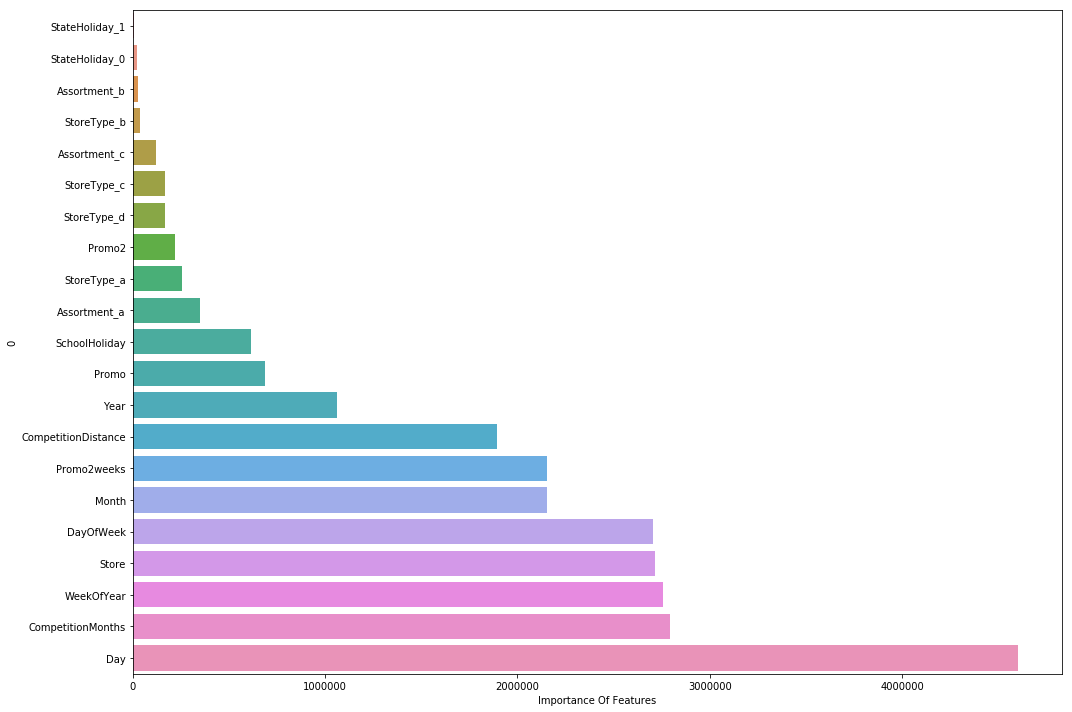

In [77]:
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=feature_import[1], y=feature_import[0], orient='h')
ax.set_xlabel("Importance Of Features")
plt.tight_layout()
plt.show()